In this notebook, we are evaluating the applicability domain of our haemolytic datasets using univariate and multivariate detection methods.

#### Working directory

In [1]:
import os
print(os.getcwd())

/Users/fabienplisson/Desktop/MODELS/Scripts


In [2]:
os.chdir('/Users/fabienplisson/Desktop/MODELS/')
print(os.getcwd())

/Users/fabienplisson/Desktop/MODELS


#### Modules

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import sklearn

In [4]:
from os import path

from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
#from sklearn.externals import joblib

#### Loading HemoPI datasets

In [7]:
HemoPI1_model = pd.read_csv('./Descriptors/HemoPI1_model.csv', index_col=0)
HemoPI1_validation = pd.read_csv('./Descriptors/HemoPI1_validation.csv', index_col=0)

In [8]:
HemoPI2_model = pd.read_csv('./Descriptors/HemoPI2_model.csv', index_col=0)
HemoPI2_validation = pd.read_csv('./Descriptors/HemoPI2_validation.csv', index_col=0)

In [9]:
HemoPI3_model = pd.read_csv('./Descriptors/HemoPI3_model.csv', index_col=0)
HemoPI3_validation = pd.read_csv('./Descriptors/HemoPI3_validation.csv', index_col=0)

#### Cleaning datasets

- Remove columns with NA values

In [10]:
cleaned_HemoPI1_model = HemoPI1_model.dropna(axis='columns')
cleaned_HemoPI1_model.shape

(884, 59)

In [11]:
cleaned_HemoPI1_validation = HemoPI1_validation.dropna(axis='columns')
cleaned_HemoPI1_validation.shape

(220, 59)

In [12]:
cleaned_HemoPI2_model = HemoPI2_model.dropna(axis='columns')
cleaned_HemoPI2_model.shape

(812, 59)

In [13]:
cleaned_HemoPI2_validation = HemoPI2_validation.dropna(axis='columns')
cleaned_HemoPI2_validation.shape

(202, 59)

In [14]:
cleaned_HemoPI3_model = HemoPI3_model.dropna(axis='columns')
cleaned_HemoPI3_model.shape

(1298, 59)

In [15]:
cleaned_HemoPI3_validation = HemoPI3_validation.dropna(axis='columns')
cleaned_HemoPI3_validation.shape

(325, 59)

- Remove duplicated columns

In [16]:
cleaned_HemoPI1_model.columns

Index(['Sequence', 'H_Eisenberg', 'uH_Eisenberg', 'H_GRAVY', 'uH_GRAVY',
       'Z3_1', 'Z3_2', 'Z3_3', ' Z5_1', 'Z5_2', 'Z5_3', ' Z5_4', 'Z5_5',
       'S_AASI', ' uS_AASI', ' modlas_ABHPRK', ' H_argos', ' uH_argos',
       ' B_Builkiness', ' uB_Builkiness', ' charge_phys', ' charge_acid',
       ' Ez', ' flexibility', ' u_flexibility', ' Grantham', ' H_HoppWoods',
       ' uH-HoppWoods', ' ISAECI', ' H_Janin', ' uH_Janin', ' H_KyteDoolittle',
       ' uH_KyteDoolittle', ' F_Levitt', ' uF_Levitt', ' MSS_shape',
       ' u_MSS_shape', ' MSW', ' pepArc', ' pepcats', ' polarity',
       ' u_polarity', ' PPCALI', ' refractivity', ' u_refractivity',
       ' t_scale', ' TM_tend', ' u_TM_tend', ' Sequence', 'Length',
       'BomanIndex', 'Aromaticity', 'AliphaticIndex', 'InstabilityIndex',
       ' NetCharge', ' MW', ' IsoelectricPoint', ' HydrophobicRatio',
       'y_model_2cl'],
      dtype='object')

In [16]:
# Sequence and Sequence are identical - remove both columns (Sequence,  Sequence)
# Remove class column prior normalization
cleaned_HemoPI1_model = cleaned_HemoPI1_model.drop(['Sequence',' Sequence', 'y_model_2cl'], axis=1)
cleaned_HemoPI1_validation = cleaned_HemoPI1_validation.drop(['Sequence',' Sequence', 'y_validation_2cl'], axis=1)
cleaned_HemoPI2_model = cleaned_HemoPI2_model.drop(['Sequence',' Sequence', 'y_model_2cl'], axis=1)
cleaned_HemoPI2_validation = cleaned_HemoPI2_validation.drop(['Sequence',' Sequence', 'y_validation_2cl'], axis=1)
cleaned_HemoPI3_model = cleaned_HemoPI3_model.drop(['Sequence',' Sequence', 'y_model_2cl'], axis=1)
cleaned_HemoPI3_validation = cleaned_HemoPI3_validation.drop(['Sequence',' Sequence', 'y_validation_2cl'], axis=1)

In [17]:
print(cleaned_HemoPI1_model.shape)
print(cleaned_HemoPI1_validation.shape)
print(cleaned_HemoPI2_model.shape)
print(cleaned_HemoPI2_validation.shape)
print(cleaned_HemoPI3_model.shape)
print(cleaned_HemoPI3_validation.shape)

(884, 56)
(220, 56)
(812, 56)
(202, 56)
(1298, 56)
(325, 56)


- Normalize datasets

In [18]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [19]:
norm_HemoPI1_model = normalize(cleaned_HemoPI1_model)
norm_HemoPI1_validation = normalize(cleaned_HemoPI1_validation)
norm_HemoPI2_model = normalize(cleaned_HemoPI2_model)
norm_HemoPI2_validation = normalize(cleaned_HemoPI2_validation)
norm_HemoPI3_model = normalize(cleaned_HemoPI3_model)
norm_HemoPI3_validation = normalize(cleaned_HemoPI3_validation)

In [20]:
norm_HemoPI1_model.to_csv('./Descriptors/norm_HemoPI1_model.csv')
norm_HemoPI1_validation.to_csv('./Descriptors/norm_HemoPI1_validation.csv')
norm_HemoPI2_model.to_csv('./Descriptors/norm_HemoPI2_model.csv')
norm_HemoPI2_validation.to_csv('./Descriptors/norm_HemoPI2_validation.csv')
norm_HemoPI3_model.to_csv('./Descriptors/norm_HemoPI3_model.csv')
norm_HemoPI3_validation.to_csv('./Descriptors/norm_HemoPI3_validation.csv')

##### Define X and y of model and validation datasets

In [21]:
X_HemoPI1_model = norm_HemoPI1_model
X_HemoPI1_validation = norm_HemoPI1_validation 
X_HemoPI2_model = norm_HemoPI2_model 
X_HemoPI2_validation = norm_HemoPI2_validation 
X_HemoPI3_model = norm_HemoPI3_model 
X_HemoPI3_validation = norm_HemoPI3_validation 

In [22]:
X_HemoPI1_model.shape

(884, 56)

In [23]:
y_HemoPI1_model = HemoPI1_model['y_model_2cl']
y_HemoPI1_validation = HemoPI1_validation['y_validation_2cl'] 
y_HemoPI2_model = HemoPI2_model['y_model_2cl'] 
y_HemoPI2_validation = HemoPI2_validation['y_validation_2cl'] 
y_HemoPI3_model = HemoPI3_model['y_model_2cl'] 
y_HemoPI3_validation = HemoPI3_validation['y_validation_2cl'] 

#### Define limits of these models

- Measure Malahanobis distance for each dataset

In [24]:
import scipy as sp
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

In [25]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [26]:
hpi1 = X_HemoPI1_model
hpi1['mahalanobis'] = mahalanobis(x=hpi1, data=X_HemoPI1_model)

# Compute the P-Values
hpi1['p_value'] = 1 - chi2.cdf(hpi1['mahalanobis'], 2)
# Extreme values with a significance level of 0.01
hpi1.loc[hpi1.p_value < 0.01].head()

,H_Eisenberg,uH_Eisenberg,H_GRAVY,uH_GRAVY,Z3_1,Z3_2,Z3_3,Z5_1,Z5_2,Z5_3,...,BomanIndex,Aromaticity,AliphaticIndex,InstabilityIndex,NetCharge,MW,IsoelectricPoint,HydrophobicRatio,mahalanobis,p_value
# ID,,,,,,,,,,,,,,,,,,,,,
peptide_pm_1,0.750249,0.321136,0.725739,0.522383,0.404082,0.776335,0.339747,0.371125,0.744425,0.342660,...,0.208411,0.071429,0.458740,0.134440,0.341862,0.153523,0.695106,0.619048,32.859772,7.321349e-08
peptide_pm_2,0.532058,0.388682,0.516632,0.493929,0.500272,0.131189,0.316909,0.507289,0.202185,0.289975,...,0.418637,0.173077,0.396799,0.154814,0.443089,0.250092,0.856694,0.454545,29.217981,4.522683e-07
peptide_pm_3,0.675110,0.575125,0.611281,0.611229,1.000000,0.041518,0.324850,0.834891,0.206068,0.287612,...,0.332182,1.000000,0.000000,0.065358,0.349033,0.081794,0.811973,0.787879,156.792646,0.000000e+00
peptide_pm_5,0.689284,0.010035,0.650197,0.021779,0.213289,0.293669,0.420437,0.207083,0.426686,0.418862,...,0.328713,0.100000,0.299482,0.267986,0.234396,0.254404,0.059629,0.590909,32.798255,7.550043e-08
peptide_pm_6,0.448718,0.505806,0.433052,0.565311,0.445970,0.410630,0.435850,0.332357,0.408210,0.337301,...,0.437273,0.214286,0.206596,0.182076,0.488650,0.184968,0.868554,0.506494,9.599271,8.232748e-03


In [27]:
hpi2 = X_HemoPI2_model
hpi2['mahalanobis'] = mahalanobis(x=hpi2, data=X_HemoPI2_model)

# Compute the P-Values
hpi2['p_value'] = 1 - chi2.cdf(hpi2['mahalanobis'], 2)
# Extreme values with a significance level of 0.01
hpi2.loc[hpi2.p_value < 0.01].head()

,H_Eisenberg,uH_Eisenberg,H_GRAVY,uH_GRAVY,Z3_1,Z3_2,Z3_3,Z5_1,Z5_2,Z5_3,...,BomanIndex,Aromaticity,AliphaticIndex,InstabilityIndex,NetCharge,MW,IsoelectricPoint,HydrophobicRatio,mahalanobis,p_value
# ID,,,,,,,,,,,,,,,,,,,,,
peptide_pm_1,0.518351,0.864043,0.397873,0.737308,0.565642,0.557679,0.497933,0.706908,0.534241,0.540278,...,0.496459,0.363636,0.219473,0.630307,0.300515,0.125455,0.965092,0.242424,99.395797,0.000000e+00
peptide_pm_2,0.895034,0.483913,0.882366,0.723517,0.415322,0.448645,0.117744,0.496553,0.287342,0.231593,...,0.123515,0.076923,0.639053,0.326764,0.192763,0.090529,0.786868,0.820513,38.763409,3.825011e-09
peptide_pm_3,0.775072,0.002264,0.718267,0.086766,0.148337,0.348626,0.433584,0.203135,0.247098,0.413270,...,0.212775,0.064516,0.278297,0.245767,0.194730,0.266872,0.504842,0.602151,39.040906,3.329468e-09
peptide_pm_5,0.712248,0.473146,0.609071,0.713917,0.509759,0.101472,0.344939,0.500320,0.126852,0.295005,...,0.231403,0.235294,0.346676,0.140261,0.328510,0.167162,0.847992,0.627451,34.175797,3.791578e-08
peptide_pm_6,0.597015,0.445342,0.621200,0.526472,0.392900,0.372056,0.395010,0.580558,0.273453,0.510959,...,0.417454,0.047619,0.527473,0.553027,0.354404,0.203496,0.993529,0.634921,15.841232,3.631786e-04


In [28]:
hpi3 = X_HemoPI3_model
hpi3['mahalanobis'] = mahalanobis(x=hpi3, data=X_HemoPI3_model)

# Compute the P-Values
hpi3['p_value'] = 1 - chi2.cdf(hpi3['mahalanobis'], 2)
# Extreme values with a significance level of 0.01
hpi3.loc[hpi3.p_value < 0.01].head()

,H_Eisenberg,uH_Eisenberg,H_GRAVY,uH_GRAVY,Z3_1,Z3_2,Z3_3,Z5_1,Z5_2,Z5_3,...,BomanIndex,Aromaticity,AliphaticIndex,InstabilityIndex,NetCharge,MW,IsoelectricPoint,HydrophobicRatio,mahalanobis,p_value
# ID,,,,,,,,,,,,,,,,,,,,,
peptide_1,0.723507,0.539601,0.742928,0.742255,0.542358,0.010047,0.381038,0.641418,0.020199,0.358935,...,0.161974,0.000000,0.830769,0.070987,0.225607,0.020953,0.766317,0.780000,78.227734,0.000000e+00
peptide_2,0.124907,0.182864,0.180008,0.188656,0.207102,0.362040,0.894358,0.483175,0.312700,0.990496,...,0.925710,0.000000,0.128698,0.893863,0.336322,0.071367,0.964063,0.162500,193.789459,0.000000e+00
peptide_4,0.574067,0.532926,0.504023,0.704814,0.461026,0.016510,0.465000,0.466756,0.018374,0.387295,...,0.314962,0.100000,0.415385,0.137305,0.308567,0.082837,0.820223,0.520000,33.709655,4.786758e-08
peptide_6,0.863026,0.355808,0.796953,0.607449,0.462382,0.374604,0.154377,0.469652,0.318894,0.177356,...,0.115890,0.272727,0.409898,0.085571,0.225607,0.083391,0.766317,0.827273,10.201557,6.092001e-03
peptide_7,0.743657,0.571116,0.629991,0.828219,0.670486,0.202368,0.331074,0.672206,0.222118,0.288013,...,0.191602,0.363636,0.377622,0.140558,0.280895,0.107531,0.808675,0.590909,46.369914,8.529055e-11


#### Mahalanobis distances and p-values for test datasets compared with model datasets

- Loading APD and HAMP datasets

In [29]:
# Load total APD test dataset
pepdesc_totalAPD = pd.read_csv('./Descriptors/pep_descriptors_totalAPD.csv', index_col=0)
globdesc_totalAPD = pd.read_csv('./Descriptors/global_descriptors_totalAPD.csv', index_col=0)
total_APD = pepdesc_totalAPD.join(globdesc_totalAPD)

total_APD.shape

# Remove duplicated columns
cleaned_total_APD = total_APD.drop(['Sequence',' Sequence'], axis=1)
cleaned_total_APD.shape

(3081, 56)

- Normalize test dataset (df) based on model dataset of choice (df2)

In [30]:
def normalize_with_model(df, df2):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df2[feature_name].max()
        min_value = df2[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [31]:
X_totalAPD_hp1 = normalize_with_model(cleaned_total_APD, cleaned_HemoPI1_model)
X_totalAPD_hp2 = normalize_with_model(cleaned_total_APD, cleaned_HemoPI2_model)
X_totalAPD_hp3 = normalize_with_model(cleaned_total_APD, cleaned_HemoPI3_model)

In [32]:
X_totalAPD_hp1.to_csv('./Descriptors/norm_totalAPD_hp1.csv')
X_totalAPD_hp2.to_csv('./Descriptors/norm_totalAPD_hp2.csv')
X_totalAPD_hp3.to_csv('./Descriptors/norm_totalAPD_hp3.csv')

- Plot probabilities results and mahalanobis distances for each top model

In [33]:
figpath = "./Figures/HemoPeps/"

/Users/fabienplisson/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


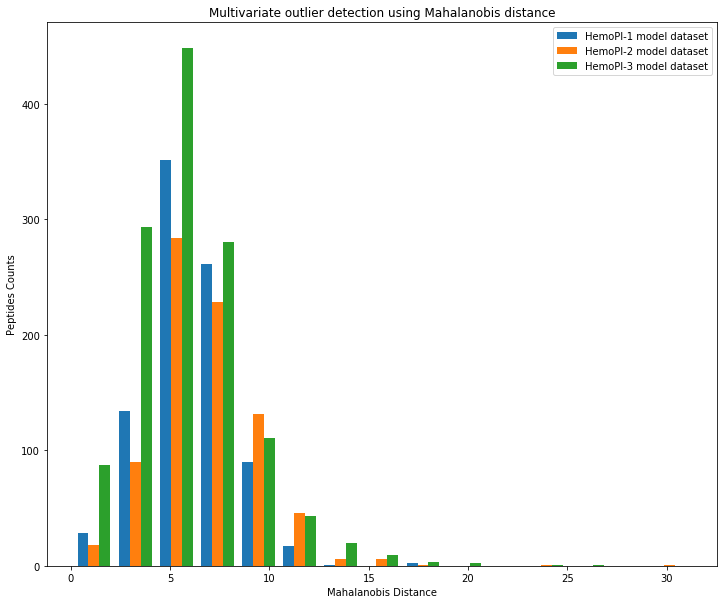

In [34]:
# Original squared Mahalanobis distance
dist_hp1_sqd = hpi1['mahalanobis']
#dist_hdbaasp_sqd = hdbaasp['mahalanobis']
dist_hp2_sqd = hpi2['mahalanobis']
dist_hp3_sqd = hpi3['mahalanobis']

# Transformed Mahalanobis distance (square root of the absolute value)
dist_hp1 = np.sqrt(np.absolute(hpi1['mahalanobis']))
#dist_hdbaasp = np.sqrt(np.absolute(hdbaasp['mahalanobis']))
dist_hp2 = np.sqrt(np.absolute(hpi2['mahalanobis']))
dist_hp3 = np.sqrt(np.absolute(hpi3['mahalanobis']))

names = ['HemoPI-1 model dataset', 'HemoPI-2 model dataset', 'HemoPI-3 model dataset']
plt.figure(figsize=(12, 10))

plt.hist(x=[dist_hp1, dist_hp2, dist_hp3], normed=False, label=names, bins=15)
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Peptides Counts')
plt.title('Multivariate outlier detection using Mahalanobis distance')
plt.legend()
#plt.savefig(path.join(figpath, "Multivariate Outlier Detection using Mahalanobis distance.pdf"))
#plt.close()
plt.show()

##### Multivariate Outlier and Novelty Detection using Empirical Rule (99.7%) in the distribution of Mahalanobis distances

In [35]:
def MD_detectOutliers(dist, dist2):
    extreme = False

    # or according to the 68–95–99.7 rule
    std = np.std(dist2)
    k = 3. * std if extreme else 2. * std
    m = np.mean(dist2)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(dist)):
        if (dist[i] >= up_t) or (dist[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

- Identify Inliers and Novelties in the 4 model datasets (Novelty is an outlier in the training set).

In [36]:
print('HemoPI-1 novelties are:', len(MD_detectOutliers(dist_hp1, dist_hp1)))
for i in MD_detectOutliers(dist_hp1, dist_hp1):
    print(hpi1.index[i])

HemoPI-1 novelties are: 47
peptide_pm_3
peptide_pm_32
peptide_pm_43
peptide_pm_47
peptide_pm_49
peptide_pm_64
peptide_pm_99
peptide_pm_112
peptide_pm_135
peptide_pm_140
peptide_pm_151
peptide_pm_298
peptide_pm_307
peptide_pm_311
peptide_pm_316
peptide_pm_332
peptide_pm_349
peptide_pm_356
peptide_pm_372
peptide_pm_399
peptide_pm_412
peptide_pm_436
peptide_nm_2
peptide_nm_17
peptide_nm_25
peptide_nm_26
peptide_nm_34
peptide_nm_61
peptide_nm_100
peptide_nm_124
peptide_nm_155
peptide_nm_165
peptide_nm_181
peptide_nm_196
peptide_nm_214
peptide_nm_252
peptide_nm_253
peptide_nm_275
peptide_nm_277
peptide_nm_283
peptide_nm_305
peptide_nm_327
peptide_nm_341
peptide_nm_361
peptide_nm_376
peptide_nm_386
peptide_nm_408


In [37]:
print('HemoPI-2 novelties are:', len(MD_detectOutliers(dist_hp2, dist_hp2)))
for i in MD_detectOutliers(dist_hp2, dist_hp2):
    print(hpi2.index[i])

HemoPI-2 novelties are: 23
peptide_pm_14
peptide_pm_107
peptide_pm_112
peptide_pm_297
peptide_nm_11
peptide_nm_24
peptide_nm_45
peptide_nm_53
peptide_nm_59
peptide_nm_96
peptide_nm_110
peptide_nm_188
peptide_nm_233
peptide_nm_234
peptide_nm_235
peptide_nm_239
peptide_nm_244
peptide_nm_265
peptide_nm_273
peptide_nm_321
peptide_nm_329
peptide_nm_344
peptide_nm_351


In [38]:
print('HemoPI-3 novelties are:', len(MD_detectOutliers(dist_hp3, dist_hp3)))
for i in MD_detectOutliers(dist_hp3, dist_hp3):
    print(hpi3.index[i])

HemoPI-3 novelties are: 50
peptide_2
peptide_28
peptide_34
peptide_56
peptide_84
peptide_179
peptide_190
peptide_193
peptide_211
peptide_361
peptide_367
peptide_382
peptide_384
peptide_460
peptide_536
peptide_544
peptide_565
peptide_580
peptide_625
peptide_707
peptide_1
peptide_10
peptide_23
peptide_25
peptide_27
peptide_31
peptide_99
peptide_150
peptide_151
peptide_152
peptide_158
peptide_159
peptide_171
peptide_179
peptide_182
peptide_184
peptide_195
peptide_295
peptide_305
peptide_306
peptide_318
peptide_326
peptide_342
peptide_444
peptide_453
peptide_474
peptide_477
peptide_509
peptide_526
peptide_548


In [39]:
def diff(list1, list2): 
    return (list(set(list1) - set(list2)))

In [40]:
def OutlierMDFinder(dataframe, dist1, dist2):
    # Create dataframe
    #dataframe = pd.DataFrame(index=dist1.index)
    dataframe['Mahalanobis'] = ''

    # Identify novelties/outliers
    novs = MD_detectOutliers(dist1, dist2).tolist()
    novs_idx = dataframe.iloc[novs]

    # Compare the entire dataset (e.g. HemoPI-1) and novelties/outliers
    alls_df = list(range(0, len(dataframe)))
    inliers_idx = dataframe.iloc[diff(alls_df, novs)]

    # Create a list 'Used method' and 1/0 (inliers/novelties)
    for n in range(len(dataframe)):
        if n in novs:
            dataframe.loc[dataframe.index[n], 'Mahalanobis'] = 1
        else:
            dataframe.loc[dataframe.index[n], 'Mahalanobis'] = 0

    return dataframe

In [41]:
novelties_hp1  = pd.DataFrame(index=dist_hp1.index)
novelties_hp1 = OutlierMDFinder(novelties_hp1, dist_hp1, dist_hp1)

novelties_hp2  = pd.DataFrame(index=dist_hp2.index)
novelties_hp2 = OutlierMDFinder(novelties_hp2, dist_hp2, dist_hp2)

novelties_hp3  = pd.DataFrame(index=dist_hp3.index)
novelties_hp3 = OutlierMDFinder(novelties_hp3, dist_hp3, dist_hp3)

#### Identify inliers and outliers of the total APD dataset based on the different model datasets

Corrected Mahalanobis distances (Square Root of Absolute Values) of total APD dataset on the different models HemoPI-1, HemoPI-2, HemoPI-3 (model) datasets and identify APD Outliers.

In [42]:
dist_apd_hp1_sqd = mahalanobis(x=X_totalAPD_hp1, data=X_totalAPD_hp1)
dist_apd_hp1 = np.sqrt(np.absolute(dist_apd_hp1_sqd))

dist_apd_hp2_sqd = mahalanobis(x=X_totalAPD_hp2, data=X_totalAPD_hp2)
dist_apd_hp2 = np.sqrt(np.absolute(dist_apd_hp2_sqd))

dist_apd_hp3_sqd = mahalanobis(x=X_totalAPD_hp3, data=X_totalAPD_hp3)
dist_apd_hp3 = np.sqrt(np.absolute(dist_apd_hp3_sqd))

In [43]:
print('APD oultiers (HemoPI-1 model) are:', len(MD_detectOutliers(dist_apd_hp1, dist_hp1)))
for i in MD_detectOutliers(dist_apd_hp1, dist_hp1):
    print(X_totalAPD_hp1.index[i])

APD oultiers (HemoPI-1 model) are: 337
AP00009
AP00024
AP00025
AP00028
AP00058
AP00061
AP00104
AP00109
AP00111
AP00141
AP00150
AP00175
AP00192
AP00202
AP00203
AP00212
AP00213
AP00270
AP00271
AP00286
AP00288
AP00302
AP00303
AP00305
AP00306
AP00308
AP00312
AP00334
AP00394
AP00395
AP00396
AP00409
AP00411
AP00421
AP00429
AP00443
AP00470
AP00495
AP00499
AP00518
AP00520
AP00523
AP00528
AP00537
AP00541
AP00550
AP00555
AP00557
AP00566
AP00590
AP00598
AP00601
AP00606
AP00607
AP00609
AP00641
AP00666
AP00672
AP00674
AP00681
AP00684
AP00689
AP00690
AP00693
AP00724
AP00725
AP00726
AP00804
AP00808
AP00810
AP00813
AP00815
AP00816
AP00821
AP00842
AP00845
AP00855
AP00859
AP00861
AP00889
AP00912
AP00920
AP00927
AP00953
AP00964
AP00979
AP00982
AP00984
AP00991
AP00994
AP01023
AP01027
AP01031
AP01032
AP01033
AP01050
AP01051
AP01052
AP01054
AP01059
AP01066
AP01073
AP01075
AP01077
AP01078
AP01079
AP01085
AP01091
AP01094
AP01100
AP01109
AP01110
AP01113
AP01114
AP01117
AP01118
AP01119
AP01120
AP01133
AP01134
A

In [44]:
outliers_apd_hp1  = pd.DataFrame(index=X_totalAPD_hp1.index)
outliers_apd_hp1 = OutlierMDFinder(outliers_apd_hp1, dist_apd_hp1, dist_hp1)
outliers_apd_hp1

,Mahalanobis
# ID,
AP00001,0
AP00002,0
AP00003,0
AP00004,0
AP00005,0
AP00006,0
AP00007,0
AP00008,0
AP00009,1


In [45]:
print('APD oultiers (HemoPI-2 model) are:', len(MD_detectOutliers(dist_apd_hp2, dist_hp2)))
for i in MD_detectOutliers(dist_apd_hp2, dist_hp2):
    print(X_totalAPD_hp2.index[i])

APD oultiers (HemoPI-2 model) are: 440
AP00002
AP00009
AP00024
AP00025
AP00033
AP00037
AP00050
AP00056
AP00070
AP00073
AP00079
AP00090
AP00094
AP00098
AP00099
AP00100
AP00104
AP00106
AP00107
AP00108
AP00109
AP00111
AP00112
AP00150
AP00161
AP00170
AP00172
AP00177
AP00185
AP00199
AP00201
AP00202
AP00203
AP00206
AP00247
AP00251
AP00270
AP00288
AP00293
AP00328
AP00334
AP00337
AP00338
AP00355
AP00362
AP00363
AP00364
AP00382
AP00391
AP00394
AP00408
AP00411
AP00414
AP00432
AP00448
AP00461
AP00462
AP00464
AP00466
AP00479
AP00495
AP00499
AP00500
AP00511
AP00514
AP00528
AP00533
AP00546
AP00551
AP00553
AP00565
AP00591
AP00593
AP00595
AP00632
AP00633
AP00635
AP00647
AP00658
AP00659
AP00665
AP00666
AP00674
AP00689
AP00690
AP00694
AP00695
AP00696
AP00703
AP00707
AP00712
AP00719
AP00729
AP00764
AP00777
AP00782
AP00789
AP00808
AP00813
AP00817
AP00818
AP00819
AP00820
AP00823
AP00826
AP00842
AP00843
AP00846
AP00848
AP00850
AP00853
AP00855
AP00864
AP00871
AP00872
AP00874
AP00875
AP00877
AP00878
AP00881
A

In [46]:
outliers_apd_hp2  = pd.DataFrame(index=X_totalAPD_hp1.index)
outliers_apd_hp2 = OutlierMDFinder(outliers_apd_hp2, dist_apd_hp2, dist_hp2)

In [47]:
print('APD oultiers (HemoPI-3 model) are:', len(MD_detectOutliers(dist_apd_hp3, dist_hp3)))
for i in MD_detectOutliers(dist_apd_hp3, dist_hp3):
    print(X_totalAPD_hp3.index[i])

APD oultiers (HemoPI-3 model) are: 89
AP00008
AP00027
AP00029
AP00141
AP00150
AP00334
AP00450
AP00499
AP00511
AP00512
AP00523
AP00528
AP00551
AP00591
AP00684
AP00802
AP00803
AP00820
AP01224
AP01225
AP01227
AP01268
AP01344
AP01357
AP01405
AP01406
AP01494
AP01518
AP01519
AP01633
AP01934
AP01937
AP01957
AP01994
AP02034
AP02055
AP02100
AP02101
AP02102
AP02183
AP02189
AP02190
AP02191
AP02192
AP02194
AP02197
AP02206
AP02207
AP02256
AP02261
AP02272
AP02336
AP02344
AP02350
AP02378
AP02379
AP02380
AP02381
AP02382
AP02383
AP02418
AP02431
AP02441
AP02450
AP02556
AP02572
AP02573
AP02574
AP02575
AP02578
AP02606
AP02622
AP02649
AP02670
AP02681
AP02727
AP02803
AP02815
AP02824
AP02838
AP02856
AP02868
AP02874
AP02884
AP02885
AP02905
AP02928
AP02984
AP03028


In [48]:
outliers_apd_hp3  = pd.DataFrame(index=X_totalAPD_hp1.index)
outliers_apd_hp3 = OutlierMDFinder(outliers_apd_hp3, dist_apd_hp3, dist_hp3)

Corrected Mahalanobis distances (Square Root of Absolute Values) of membranolytic AMPs (mAMPs) dataset on the different models HemoPI-1, HDBAASP, HemoPI-2, HemoPI-3 (model) datasets and identify mAMPs Outliers.

#### Projections of Inliers, Novelties and Outliers with Probability Consensus Hemolytic Activity vs Mahalanobis Distance

1. HemoPI-1 dataset and total APD dataset

In [49]:
results_models_hpi1 = pd.read_csv('./Results/predictions_models_HemoPI1.csv', index_col=0)
results_models_hpi1.head()

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1,consensus_class_preds,consensus_probability_0,consensus_probability_1
# ID,,,,,,,,,,,,
peptide_pm_1,1,0.000063,0.999937,1,0.000036,0.999964,1,0.000053,0.999947,1,0.000051,0.999949
peptide_pm_2,1,0.001484,0.998516,1,0.000065,0.999935,1,0.000052,0.999948,1,0.000533,0.999467
peptide_pm_3,1,0.000198,0.999802,1,0.000019,0.999981,1,0.000011,0.999989,1,0.000076,0.999924
peptide_pm_4,1,0.000120,0.999880,1,0.000025,0.999975,1,0.000032,0.999968,1,0.000059,0.999941
peptide_pm_5,1,0.139772,0.860228,1,0.001218,0.998782,1,0.001809,0.998191,1,0.047600,0.952400


In [50]:
results_models_hpi1_apd = pd.read_csv('./Results/predictions_totalAPD_HemoPI1_topmodels.csv', index_col=0)
results_models_hpi1_apd.head()

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1,consensus_class_preds,consensus_probability_0,consensus_probability_1
# ID,,,,,,,,,,,,
AP00001,1,0.043748,0.956252,1,0.097511,0.902489,1,0.358041,0.641959,1,0.166433,0.833567
AP00002,0,0.963566,0.036434,1,0.427008,0.572992,0,0.666258,0.333742,0,0.685611,0.314389
AP00003,1,0.093772,0.906228,0,0.907247,0.092753,0,0.886021,0.113979,0,0.629013,0.370987
AP00004,1,0.461297,0.538703,1,0.481127,0.518873,0,0.960292,0.039708,0,0.634239,0.365761
AP00005,0,0.500031,0.499969,0,0.673249,0.326751,0,0.847562,0.152438,0,0.673614,0.326386


In [51]:
probs = pd.Series(results_models_hpi1['consensus_probability_1']).to_frame()
preds = pd.Series(results_models_hpi1['consensus_class_preds']).to_frame()
dists = dist_hp1.to_frame()


probs_apd = pd.Series(results_models_hpi1_apd['consensus_probability_1']).to_frame()
preds_apd = pd.Series(results_models_hpi1_apd['consensus_class_preds']).to_frame()
dists_apd = pd.DataFrame(dist_apd_hp1, index=X_totalAPD_hp1.index)
dists_apd.columns=['mahalanobis']


hpi1_df = pd.concat([preds, probs, dists], axis=1)
apd_hpi1_df = pd.concat([preds_apd, probs_apd, dists_apd], axis=1)

In [52]:
print(len(hpi1_df), len(apd_hpi1_df))

884 3081


##### Add HAMP dataset

In [53]:
# Define HAMP dataset - 317 "true" (validated) haemolytic AMPs
haemolytic_APD = pd.read_csv('./Data/hemolytic_APD.csv', index_col=0)

# We use APD ID to match with APD inliers and outliers
haemolytic_APD_idx = haemolytic_APD.index.values

In [54]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

<Figure size 360x1080 with 0 Axes>

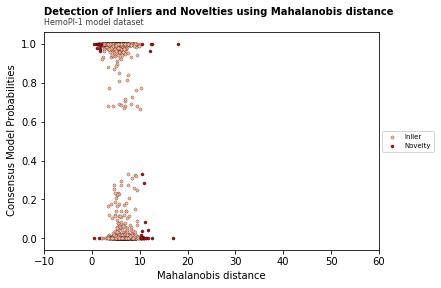

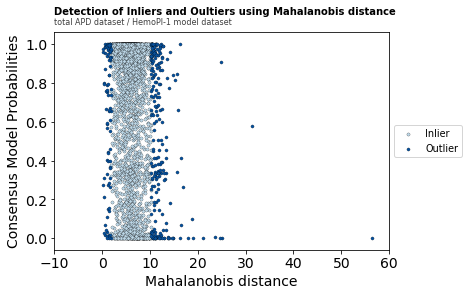

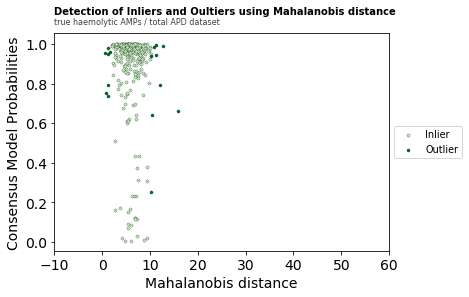

In [55]:
# Identify inliers and novelties
novs = MD_detectOutliers(dist_hp1, dist_hp1).tolist()
novs_df = hpi1_df.iloc[novs]

#merged_df = pd.concat([hpi1_df, novs_df])
#inliers_df = merged_df.drop_duplicates(keep=False)
alls_df = list(range(0, len(hpi1_df)))
inliers_df = hpi1_df.iloc[diff(alls_df, novs)]

fig = plt.figure(figsize = (5,15))
fig, ax = plt.subplots()

ax = sns.regplot(x= 'mahalanobis', y='consensus_probability_1', data=inliers_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#fcae91', 'linewidths': 0.2}, label='Inlier')
ax = sns.regplot(x= 'mahalanobis', y='consensus_probability_1', data=novs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#a50f15', 'linewidths': 0.2}, label='Novelty')

ax.text(x=-10, y=1.15, s='Detection of Inliers and Novelties using Mahalanobis distance', fontsize=10, weight='bold')
ax.text(x=-10, y=1.1, s='HemoPI-1 model dataset', fontsize=8, alpha=0.75)
ax.set(xlabel='Mahalanobis distance', ylabel=' Consensus Model Probabilities')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax.set(xlim=(-10, 60))

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Novelties in HemoPI-1 Model 1.1 dataset_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

# Identify inliers and outliers
outs = MD_detectOutliers(dist_apd_hp1, dist_hp1).tolist()
outs_df = apd_hpi1_df.iloc[outs]

alls_df2 = list(range(0, len(apd_hpi1_df)))
inliers_df2 = apd_hpi1_df.iloc[diff(alls_df2, outs)]

#fig = plt.figure(figsize = (10,10))
fig, ax2 = plt.subplots()

ax2 = sns.regplot(x= 'mahalanobis', y='consensus_probability_1', data=inliers_df2, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#bdd7e7', 'linewidths': 0.2}, label='Inlier')
ax2 = sns.regplot(x= 'mahalanobis', y='consensus_probability_1', data=outs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#08519c', 'linewidths': 0.2}, label='Outlier')

ax2.text(x=-10, y=1.15, s='Detection of Inliers and Oultiers using Mahalanobis distance', fontsize=10, weight='bold')
ax2.text(x=-10, y=1.1, s='total APD dataset / HemoPI-1 model dataset', fontsize=8, alpha=0.75)
ax2.set(xlabel='Mahalanobis distance', ylabel='Consensus Model Probabilities')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax2.set(xlim=(-10, 60))

#ax2.vlines(chi2.ppf(0.995, 2), 0, 1, label ="99.7% $\chi^2$ quantile", linestyles = (0, (5, 5)), linewidth=0.5, color="gray")

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Outliers in total APD dataset according to HemoPI-1 Model 1.1_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

# Subset the list of indices for True Haemolytic AMPs (HAMPs)
outlier_APD_idx = outs_df.index
outlier_HAMP_idx = intersection(outlier_APD_idx, haemolytic_APD_idx)
outs_df = outs_df.loc[outlier_HAMP_idx]

inlier_APD_idx = inliers_df2.index
inlier_HAMP_idx = intersection(inlier_APD_idx, haemolytic_APD_idx)
inliers_df2 = inliers_df2.loc[inlier_HAMP_idx]

fig, ax2 = plt.subplots()

ax2 = sns.regplot(x= 'mahalanobis', y='consensus_probability_1', data=inliers_df2, fit_reg=False, marker='o', scatter_kws={"color":"black",'facecolors': "#bae4b3",  "alpha": 1.0, 's':10, 'linewidths': 0.2}, label='Inlier')
ax2 = sns.regplot(x= 'mahalanobis', y='consensus_probability_1', data=outs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", 'facecolors': "#006d2c",  "alpha": 1.0, 's':10, 'linewidths': 0.2}, label='Outlier')

ax2.text(x=-10, y=1.15, s='Detection of Inliers and Oultiers using Mahalanobis distance', fontsize=10, weight='bold')
ax2.text(x=-10, y=1.1, s='true haemolytic AMPs / total APD dataset', fontsize=8, alpha=0.75)
ax2.set(xlabel='Mahalanobis distance', ylabel='Consensus Model Probabilities')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax2.set(xlim=(-10, 60))

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Outliers among true haemolytic AMPs in total APD dataset according to HemoPI-1 Model 1.1_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

In [56]:
outlier_APD_idx = outs_df.index
outlier_HAMP_idx = intersection(outlier_APD_idx, haemolytic_APD_idx)
outs_df = outs_df.loc[outlier_HAMP_idx]

inlier_APD_idx = inliers_df2.index
inlier_HAMP_idx = intersection(inlier_APD_idx, haemolytic_APD_idx)
inliers_df2 = inliers_df2.loc[inlier_HAMP_idx]

print(len(outs_df), len(inliers_df2))

16 301


In [57]:
len(outs_df) + len(inliers_df2)

317

In [58]:
# Subset dataframes, Add primary sequence to all subgroups (Md Inliers, Md Novelties, APD Inliers, APD oultiers)
hpi1_inliers = HemoPI1_model[HemoPI1_model.index.isin(inliers_df.index)]
hpi1_inliers = hpi1_inliers.loc[:, 'Sequence']
hpi1_inliers = pd.DataFrame(hpi1_inliers)
hpi1_inliers['Group'] = 'Md Inliers'

hpi1_novs = HemoPI1_model[HemoPI1_model.index.isin(novs_df.index)]
hpi1_novs = hpi1_novs.loc[:, 'Sequence']
hpi1_novs = pd.DataFrame(hpi1_novs)
hpi1_novs['Group'] = 'Md Novelties'

hpi1_apd_inliers = total_APD[total_APD.index.isin(inliers_df2.index)]
hpi1_apd_inliers = hpi1_apd_inliers.loc[:, 'Sequence']
hpi1_apd_inliers = pd.DataFrame(hpi1_apd_inliers)
hpi1_apd_inliers['Group'] = 'APD Inliers'

hpi1_apd_outliers = total_APD[total_APD.index.isin(outs_df.index)]
hpi1_apd_outliers = hpi1_apd_outliers.loc[:, 'Sequence']
hpi1_apd_outliers = pd.DataFrame(hpi1_apd_outliers)
hpi1_apd_outliers['Group'] = 'APD Outliers'

# Create a summary table .csv
hpi1_io = pd.concat([hpi1_inliers, hpi1_novs, hpi1_apd_inliers, hpi1_apd_outliers], axis=0)
hpi1_io.to_csv('./Results/HemoPI-1 Inliers Novelties and Outliers.csv')

In [59]:
len(hpi1_apd_inliers) + len(hpi1_apd_outliers)

317

2.HemoPI-2 dataset and total APD dataset

In [60]:
results_models_hpi2 = pd.read_csv('./Results/predictions_models_HemoPI2.csv', index_col=0)
results_models_hpi2.head()

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1,consensus_class_preds,consensus_probability_0,consensus_probability_1
# ID,,,,,,,,,,,,
peptide_pm_1,1,0.142105,0.857895,1,0.234876,0.765124,1,0.221635,0.778365,1,0.199539,0.800461
peptide_pm_2,1,0.037029,0.962971,1,0.126394,0.873606,1,0.094989,0.905011,1,0.086138,0.913862
peptide_pm_3,1,0.048425,0.951575,1,0.131344,0.868656,1,0.101591,0.898409,1,0.093787,0.906213
peptide_pm_4,1,0.045721,0.954279,1,0.121016,0.878984,1,0.090289,0.909711,1,0.085675,0.914325
peptide_pm_5,1,0.083319,0.916681,1,0.122988,0.877012,1,0.132518,0.867482,1,0.112942,0.887058


In [61]:
results_models_apd = pd.read_csv('./Results/predictions_totalAPD_topmodels_high&lowhemolysis.csv', index_col=0)
results_models_apd.head()

,model1_hp2_class_preds,model1_hp2_probability_0,model1_hp2_probability_1,model1_hp3_class_preds,model1_hp3_probability_0,model1_hp3_probability_1,model2_hdbaasp_class_preds,model2_hdbaasp_probability_0,model2_hdbaasp_probability_1,consensus_hdbaasp_class_preds,consensus_hdbaasp_probability_0,consensus_hdbaasp_probability_1
# ID,,,,,,,,,,,,
AP00001,0,0.703185,0.296815,1,0.198319,0.801681,0,0.862623,0.137377,0,0.703185,0.296815
AP00002,0,0.666658,0.333342,0,0.994193,0.005807,1,0.004876,0.995124,0,0.666658,0.333342
AP00003,0,0.913113,0.086887,0,0.904319,0.095681,1,0.006725,0.993275,0,0.904319,0.095681
AP00004,0,0.941226,0.058774,0,0.797031,0.202969,1,0.003430,0.996570,0,0.797031,0.202969
AP00005,0,0.837621,0.162379,1,0.042720,0.957280,1,0.007294,0.992706,1,0.042720,0.957280


In [66]:
probs = pd.Series(results_models_hpi2['model1_probability_1']).to_frame()
preds = pd.Series(results_models_hpi2['model1_class_preds']).to_frame()
dists = dist_hp2.to_frame()

probs_apd = pd.Series(results_models_apd['model1_hp2_probability_1']).to_frame()
preds_apd = pd.Series(results_models_apd['model1_hp2_class_preds']).to_frame()
dists_apd = pd.DataFrame(dist_apd_hp2, index=X_totalAPD_hp2.index)
dists_apd.columns=['mahalanobis']

hpi2_df = pd.concat([preds, probs, dists], axis=1)
apd_hpi2_df = pd.concat([preds_apd, probs_apd, dists_apd], axis=1)

<Figure size 360x1080 with 0 Axes>

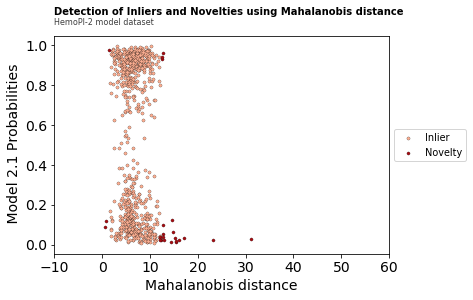

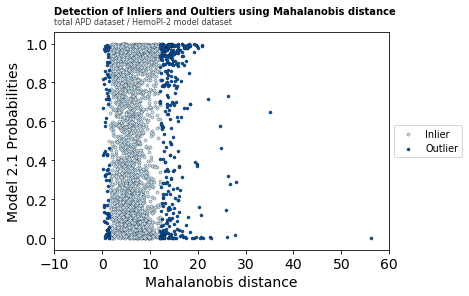

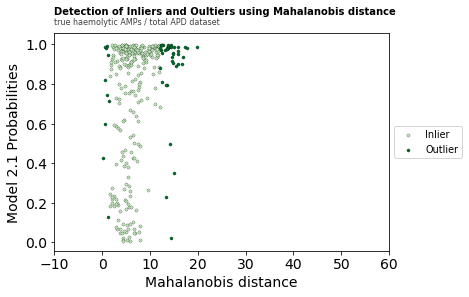

In [67]:
# Identify inliers and novelties
novs = MD_detectOutliers(dist_hp2, dist_hp2).tolist()
novs_df = hpi2_df.iloc[novs]

#merged_df = pd.concat([hpi2_df, novs_df])
#inliers_df = merged_df.drop_duplicates(keep=False)
alls_df = list(range(0, len(hpi2_df)))
inliers_df = hpi2_df.iloc[diff(alls_df, novs)]

fig = plt.figure(figsize = (5,15))
fig, ax = plt.subplots()

ax = sns.regplot(x= 'mahalanobis', y='model1_probability_1', data=inliers_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#fcae91', 'linewidths': 0.2}, label='Inlier')
ax = sns.regplot(x= 'mahalanobis', y='model1_probability_1', data=novs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#a50f15', 'linewidths': 0.2}, label='Novelty')

ax.text(x=-10, y=1.15, s='Detection of Inliers and Novelties using Mahalanobis distance', fontsize=10, weight='bold')
ax.text(x=-10, y=1.1, s='HemoPI-2 model dataset', fontsize=8, alpha=0.75)
ax.set(xlabel='Mahalanobis distance', ylabel=' Model 2.1 Probabilities')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax.set(xlim=(-10, 60))

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Novelties in HemoPI-2 Model 2.1 dataset_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

# Identify inliers and outliers
outs = MD_detectOutliers(dist_apd_hp2, dist_hp2).tolist()
outs_df = apd_hpi2_df.iloc[outs]

alls_df2 = list(range(0, len(apd_hpi2_df)))
inliers_df2 = apd_hpi2_df.iloc[diff(alls_df2, outs)]

#fig = plt.figure(figsize = (10,10))
fig, ax2 = plt.subplots()

ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp2_probability_1', data=inliers_df2, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#bdd7e7', 'linewidths': 0.2}, label='Inlier')
ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp2_probability_1', data=outs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#08519c', 'linewidths': 0.2}, label='Outlier')

ax2.text(x=-10, y=1.15, s='Detection of Inliers and Oultiers using Mahalanobis distance', fontsize=10, weight='bold')
ax2.text(x=-10, y=1.1, s='total APD dataset / HemoPI-2 model dataset', fontsize=8, alpha=0.75)
ax2.set(xlabel='Mahalanobis distance', ylabel='Model 2.1 Probabilities')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax2.set(xlim=(-10, 60))

#ax2.vlines(chi2.ppf(0.995, 2), 0, 1, label ="99.7% $\chi^2$ quantile", linestyles = (0, (5, 5)), linewidth=0.5, color="gray")

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Outliers in total APD dataset according to HemoPI-1 Model 1.1_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

# Subset the list of indices for True Haemolytic AMPs (HAMPs)
outlier_APD_idx = outs_df.index
outlier_HAMP_idx = intersection(outlier_APD_idx, haemolytic_APD_idx)
outs_df = outs_df.loc[outlier_HAMP_idx]

inlier_APD_idx = inliers_df2.index
inlier_HAMP_idx = intersection(inlier_APD_idx, haemolytic_APD_idx)
inliers_df2 = inliers_df2.loc[inlier_HAMP_idx]

fig, ax2 = plt.subplots()

ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp2_probability_1', data=inliers_df2, fit_reg=False, marker='o', scatter_kws={"color":"black",'facecolors': "#bae4b3",  "alpha": 1.0, 's':10, 'linewidths': 0.2}, label='Inlier')
ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp2_probability_1', data=outs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", 'facecolors': "#006d2c",  "alpha": 1.0, 's':10, 'linewidths': 0.2}, label='Outlier')

ax2.text(x=-10, y=1.15, s='Detection of Inliers and Oultiers using Mahalanobis distance', fontsize=10, weight='bold')
ax2.text(x=-10, y=1.1, s='true haemolytic AMPs / total APD dataset', fontsize=8, alpha=0.75)
ax2.set(xlabel='Mahalanobis distance', ylabel='Model 2.1 Probabilities')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax2.set(xlim=(-10, 60))

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Outliers among true haemolytic AMPs in total APD dataset according to HemoPI-1 Model 1.1_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

In [68]:
outlier_APD_idx = outs_df.index
outlier_HAMP_idx = intersection(outlier_APD_idx, haemolytic_APD_idx)
outs_df = outs_df.loc[outlier_HAMP_idx]

inlier_APD_idx = inliers_df2.index
inlier_HAMP_idx = intersection(inlier_APD_idx, haemolytic_APD_idx)
inliers_df2 = inliers_df2.loc[inlier_HAMP_idx]

print(len(outs_df), len(inliers_df2))

52 265


In [69]:
# Subset dataframes, Add primary sequence to all subgroups (Md Inliers, Md Novelties, APD Inliers, APD oultiers)
hpi2_inliers = HemoPI2_model[HemoPI2_model.index.isin(inliers_df.index)]
hpi2_inliers = hpi2_inliers.loc[:, 'Sequence']
hpi2_inliers = pd.DataFrame(hpi2_inliers)
hpi2_inliers['Group'] = 'Md Inliers'

hpi2_novs = HemoPI2_model[HemoPI2_model.index.isin(novs_df.index)]
hpi2_novs = hpi2_novs.loc[:, 'Sequence']
hpi2_novs = pd.DataFrame(hpi2_novs)
hpi2_novs['Group'] = 'Md Novelties'

hpi2_apd_inliers = total_APD[total_APD.index.isin(inliers_df2.index)]
hpi2_apd_inliers = hpi2_apd_inliers.loc[:, 'Sequence']
hpi2_apd_inliers = pd.DataFrame(hpi2_apd_inliers)
hpi2_apd_inliers['Group'] = 'APD Inliers'

hpi2_apd_outliers = total_APD[total_APD.index.isin(outs_df.index)]
hpi2_apd_outliers = hpi2_apd_outliers.loc[:, 'Sequence']
hpi2_apd_outliers = pd.DataFrame(hpi2_apd_outliers)
hpi2_apd_outliers['Group'] = 'APD Outliers'

# Create a summary table .csv
hpi2_io = pd.concat([hpi2_inliers, hpi2_novs, hpi2_apd_inliers, hpi2_apd_outliers], axis=0)
hpi2_io.to_csv('./Results/HemoPI-2 Inliers Novelties and Outliers.csv')

HemoPI-3 dataset and total APD dataset

In [70]:
results_models_hpi3 = pd.read_csv('./Results/predictions_models_HemoPI3.csv', index_col=0)
results_models_hpi3.head()

,model1_class_preds,model1_probability_0,model1_probability_1,model2_class_preds,model2_probability_0,model2_probability_1,model3_class_preds,model3_probability_0,model3_probability_1,consensus_class_preds,consensus_probability_0,consensus_probability_1
# ID,,,,,,,,,,,,
peptide_1,1,0.000738,0.999262,1,0.001003,0.998997,1,0.017404,0.982596,1,0.006382,0.993618
peptide_2,1,0.000717,0.999283,1,0.000999,0.999001,1,0.022623,0.977377,1,0.008113,0.991887
peptide_3,1,0.000319,0.999681,1,0.000622,0.999378,1,0.012779,0.987221,1,0.004573,0.995427
peptide_4,1,0.001485,0.998515,1,0.003315,0.996685,1,0.031623,0.968377,1,0.012141,0.987859
peptide_5,1,0.000547,0.999453,1,0.000976,0.999024,1,0.011745,0.988255,1,0.004423,0.995577


In [71]:
probs = pd.Series(results_models_hpi3['model1_probability_1']).to_frame()
preds = pd.Series(results_models_hpi3['model1_class_preds']).to_frame()
dists = dist_hp3.to_frame()

probs_apd = pd.Series(results_models_apd['model1_hp3_probability_1']).to_frame()
preds_apd = pd.Series(results_models_apd['model1_hp3_class_preds']).to_frame()
dists_apd = pd.DataFrame(dist_apd_hp3, index=X_totalAPD_hp3.index)
dists_apd.columns=['mahalanobis']

hpi3_df = pd.concat([preds, probs, dists], axis=1)
apd_hpi3_df = pd.concat([preds_apd, probs_apd, dists_apd], axis=1)

<Figure size 360x1080 with 0 Axes>

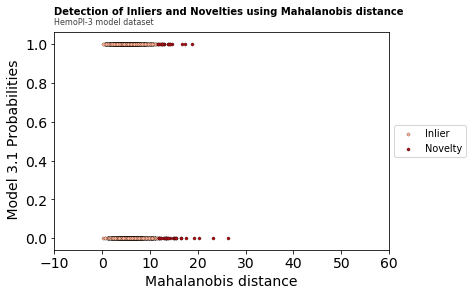

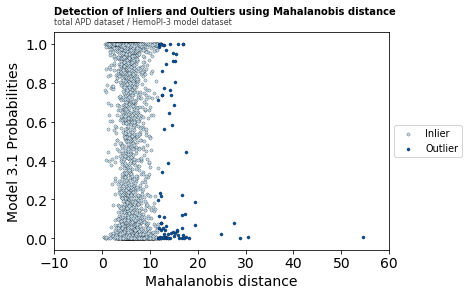

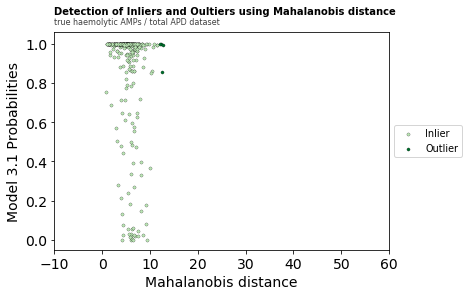

In [72]:
# Identify inliers and novelties
novs = MD_detectOutliers(dist_hp3, dist_hp3).tolist()
novs_df = hpi3_df.iloc[novs]

#merged_df = pd.concat([hpi3_df, novs_df])
#inliers_df = merged_df.drop_duplicates(keep=False)
alls_df = list(range(0, len(hpi3_df)))
inliers_df = hpi3_df.iloc[diff(alls_df, novs)]

fig = plt.figure(figsize = (5,15))
fig, ax = plt.subplots()

ax = sns.regplot(x= 'mahalanobis', y='model1_probability_1', data=inliers_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#fcae91', 'linewidths': 0.2}, label='Inlier')
ax = sns.regplot(x= 'mahalanobis', y='model1_probability_1', data=novs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#a50f15', 'linewidths': 0.2}, label='Novelty')

ax.text(x=-10, y=1.15, s='Detection of Inliers and Novelties using Mahalanobis distance', fontsize=10, weight='bold')
ax.text(x=-10, y=1.1, s='HemoPI-3 model dataset', fontsize=8, alpha=0.75)
ax.set(xlabel='Mahalanobis distance', ylabel=' Model 3.1 Probabilities')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax.set(xlim=(-10, 60))

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Novelties in HemoPI-3 Model 3.1 dataset_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

# Identify inliers and outliers
outs = MD_detectOutliers(dist_apd_hp3, dist_hp3).tolist()
outs_df = apd_hpi3_df.iloc[outs]

alls_df2 = list(range(0, len(apd_hpi3_df)))
inliers_df2 = apd_hpi3_df.iloc[diff(alls_df2, outs)]

#fig = plt.figure(figsize = (10,10))
fig, ax2 = plt.subplots()

ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp3_probability_1', data=inliers_df2, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#bdd7e7', 'linewidths': 0.2}, label='Inlier')
ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp3_probability_1', data=outs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", "alpha": 1.0, 's':10, 'facecolors':'#08519c', 'linewidths': 0.2}, label='Outlier')

ax2.text(x=-10, y=1.15, s='Detection of Inliers and Oultiers using Mahalanobis distance', fontsize=10, weight='bold')
ax2.text(x=-10, y=1.1, s='total APD dataset / HemoPI-3 model dataset', fontsize=8, alpha=0.75)
ax2.set(xlabel='Mahalanobis distance', ylabel='Model 3.1 Probabilities')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax2.set(xlim=(-10, 60))

#ax2.vlines(chi2.ppf(0.995, 2), 0, 1, label ="99.7% $\chi^2$ quantile", linestyles = (0, (5, 5)), linewidth=0.5, color="gray")

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Outliers in total APD dataset according to HemoPI-3 Model 3.1_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

# Subset the list of indices for True Haemolytic AMPs (HAMPs)
outlier_APD_idx = outs_df.index
outlier_HAMP_idx = intersection(outlier_APD_idx, haemolytic_APD_idx)
outs_df = outs_df.loc[outlier_HAMP_idx]

inlier_APD_idx = inliers_df2.index
inlier_HAMP_idx = intersection(inlier_APD_idx, haemolytic_APD_idx)
inliers_df2 = inliers_df2.loc[inlier_HAMP_idx]

fig, ax2 = plt.subplots()

ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp3_probability_1', data=inliers_df2, fit_reg=False, marker='o', scatter_kws={"color":"black",'facecolors': "#bae4b3",  "alpha": 1.0, 's':10, 'linewidths': 0.2}, label='Inlier')
ax2 = sns.regplot(x= 'mahalanobis', y='model1_hp3_probability_1', data=outs_df, fit_reg=False, marker='o', scatter_kws={"color":"black", 'facecolors': "#006d2c",  "alpha": 1.0, 's':10, 'linewidths': 0.2}, label='Outlier')

ax2.text(x=-10, y=1.15, s='Detection of Inliers and Oultiers using Mahalanobis distance', fontsize=10, weight='bold')
ax2.text(x=-10, y=1.1, s='true haemolytic AMPs / total APD dataset', fontsize=8, alpha=0.75)
ax2.set(xlabel='Mahalanobis distance', ylabel='Model 3.1 Probabilities')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'x-small')
ax2.set(xlim=(-10, 60))

plt.rcParams.update({'font.size': 14})
#plt.savefig(path.join(figpath, "Detection of Outliers among true haemolytic AMPs in total APD dataset according to HemoPI-1 Model 1.1_Mahalanobis_colored.pdf"))
#plt.close()
plt.show()

In [73]:
outlier_APD_idx = outs_df.index
outlier_HAMP_idx = intersection(outlier_APD_idx, haemolytic_APD_idx)
outs_df = outs_df.loc[outlier_HAMP_idx]

inlier_APD_idx = inliers_df2.index
inlier_HAMP_idx = intersection(inlier_APD_idx, haemolytic_APD_idx)
inliers_df2 = inliers_df2.loc[inlier_HAMP_idx]

print(len(outs_df), len(inliers_df2))

4 313


In [75]:
# Subset dataframes, Add primary sequence to all subgroups (Md Inliers, Md Novelties, APD Inliers, APD oultiers)
hpi3_inliers = HemoPI3_model[HemoPI3_model.index.isin(inliers_df.index)]
hpi3_inliers = hpi3_inliers.loc[:, 'Sequence']
hpi3_inliers = pd.DataFrame(hpi3_inliers)
hpi3_inliers['Group'] = 'Md Inliers'

hpi3_novs = HemoPI3_model[HemoPI3_model.index.isin(novs_df.index)]
hpi3_novs = hpi3_novs.loc[:, 'Sequence']
hpi3_novs = pd.DataFrame(hpi3_novs)
hpi3_novs['Group'] = 'Md Novelties'

hpi3_apd_inliers = total_APD[total_APD.index.isin(inliers_df2.index)]
hpi3_apd_inliers = hpi3_apd_inliers.loc[:, 'Sequence']
hpi3_apd_inliers = pd.DataFrame(hpi3_apd_inliers)
hpi3_apd_inliers['Group'] = 'APD Inliers'

hpi3_apd_outliers = total_APD[total_APD.index.isin(outs_df.index)]
hpi3_apd_outliers = hpi3_apd_outliers.loc[:, 'Sequence']
hpi3_apd_outliers = pd.DataFrame(hpi3_apd_outliers)
hpi3_apd_outliers['Group'] = 'APD Outliers'

# Create a summary table .csv
hpi3_io = pd.concat([hpi3_inliers, hpi3_novs, hpi3_apd_inliers, hpi3_apd_outliers], axis=0)
hpi3_io.to_csv('./Results/HemoPI-3 Inliers Novelties and Outliers.csv')

Using Mahalanobis distance and the empirical rule covering 99.7% of the distribution for each dataset (3 standard deviations from mean), we were able to identify inliers, novelties and outliers for each model and APD sets. Novelties are extreme observations of the model set representing 0.3% of that distribution however they were still taken into account while building models. Therefore we should apply multivariate outlier detection techniques (ABOD, CBLOF, FB, HBOS, IForest, KK, LOF) that minimize the number of novelties in the model datasets leading to reduce the number of outliers in APD dataset. 

##### Using other multivariate outlier detection techniques

Zhao, Y., Nasrullah, Z. and Li, Z., 2019. PyOD: A Python Toolbox for Scalable Outlier Detection. Journal of machine learning research (JMLR), 20(96), pp.1-7

- https://pyod.readthedocs.io/en/latest/
- https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561
- https://scikit-learn.org/stable/modules/outlier_detection.html

In [76]:
import pyod

In [77]:
from pyod.utils.data import get_outliers_inliers

In [78]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

/Users/fabienplisson/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [79]:
from sklearn.covariance import EllipticEnvelope

In [80]:
from scipy import stats 
import matplotlib

In [81]:
from sklearn.manifold import TSNE
import time

##### Load datasets

In [91]:
# 56 Physicochemical descriptors
# Model datasets
X_HemoPI1_model
X_HemoPI2_model
X_HemoPI3_model

#Total APD / Model datasets
X_totalAPD_hp1
X_totalAPD_hp2
X_totalAPD_hp3

,H_Eisenberg,uH_Eisenberg,H_GRAVY,uH_GRAVY,Z3_1,Z3_2,Z3_3,Z5_1,Z5_2,Z5_3,...,u_TM_tend,Length,BomanIndex,Aromaticity,AliphaticIndex,InstabilityIndex,NetCharge,MW,IsoelectricPoint,HydrophobicRatio
# ID,,,,,,,,,,,,,,,,,,,,,
AP00001,0.752917,0.211642,0.664832,0.278638,0.147713,0.403006,0.140439,0.179542,0.294820,0.149777,...,0.280223,0.322917,0.226448,0.030303,0.337816,0.152433,0.225580,0.261790,0.736824,0.669697
AP00002,0.709186,0.112289,0.499280,0.158822,0.215570,0.367348,0.246339,0.276585,0.230541,0.253115,...,0.106569,0.333333,0.291096,0.176471,0.142012,0.340858,0.253168,0.327140,0.780775,0.267647
AP00003,0.667040,0.079351,0.543896,0.133697,0.159616,0.348215,0.404806,0.229567,0.232259,0.381286,...,0.145718,0.541667,0.341683,0.111111,0.095989,0.274486,0.194864,0.521306,0.501963,0.409259
AP00004,0.649079,0.037821,0.508655,0.093430,0.210752,0.369203,0.407671,0.278911,0.285304,0.382483,...,0.021796,0.489583,0.373741,0.122449,0.078251,0.175593,0.167275,0.489938,0.479306,0.397959
AP00005,0.771609,0.345622,0.668358,0.591179,0.378000,0.213853,0.161293,0.399261,0.176335,0.194564,...,0.472631,0.333333,0.247851,0.088235,0.417682,0.168582,0.143754,0.315126,0.479006,0.650000
AP00006,0.611007,0.052416,0.425550,0.105653,0.169770,0.248694,0.335912,0.283105,0.173328,0.366329,...,0.125234,0.166667,0.409990,0.055556,0.211045,0.264896,0.226714,0.161128,0.870802,0.216667
AP00007,0.605410,0.045166,0.419743,0.095117,0.163539,0.240547,0.335359,0.293825,0.168331,0.362277,...,0.121126,0.166667,0.409990,0.055556,0.211045,0.264896,0.226714,0.161128,0.870802,0.216667
AP00008,0.641231,0.448556,0.789714,0.511472,0.316025,0.259882,0.672129,0.452745,0.268682,0.755847,...,0.300030,0.104167,0.379515,0.000000,0.603550,0.139736,0.244784,0.102744,0.853111,0.866667
AP00009,0.671650,0.122628,0.527428,0.188064,0.277586,0.146545,0.425169,0.381278,0.119987,0.450356,...,0.163964,0.427083,0.344855,0.162791,0.193202,0.458308,0.391582,0.446230,0.949466,0.362791


In [87]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging': FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state, behaviour="new"),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor': LOF(contamination=outliers_fraction)
}

 ##### Model HemoPI-1 dataset

In [96]:
X_HemoPI1_model.shape

(884, 58)

In [97]:
X_HemoPI1_model.drop(['mahalanobis', 'p_value'], axis=1, inplace=True)

In [92]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI1_model.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = novelties_hp1
    dfx[clf_name] = y_pred.tolist()

         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

OUTLIERS :  59 INLIERS :  825 Angle-based Outlier Detector (ABOD)
OUTLIERS :  45 INLIERS :  839 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  32 INLIERS :  852 Feature Bagging
OUTLIERS :  45 INLIERS :  839 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  45 INLIERS :  839 Isolation Forest
OUTLIERS :  33 INLIERS :  851 K Nearest Neighbors (KNN)
OUTLIERS :  20 INLIERS :  864 Average KNN
OUTLIERS :  36 INLIERS :  848 Local Outlier Factor


In [1013]:
#Save results for dataframe novelties_hp1
novelties_hp1.to_csv('./Results/novelties_hp1.csv')

##### total APD / HemoPI-1 dataset

In [98]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI1_model.values
X2 = X_totalAPD_hp1.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X2) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X2)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = outliers_apd_hp1
    dfx[clf_name] = y_pred.tolist()
        
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

OUTLIERS :  337 INLIERS :  2744 Angle-based Outlier Detector (ABOD)
OUTLIERS :  280 INLIERS :  2801 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  216 INLIERS :  2865 Feature Bagging
OUTLIERS :  157 INLIERS :  2924 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  152 INLIERS :  2929 Isolation Forest
OUTLIERS :  262 INLIERS :  2819 K Nearest Neighbors (KNN)
OUTLIERS :  274 INLIERS :  2807 Average KNN
OUTLIERS :  267 INLIERS :  2814 Local Outlier Factor


In [1018]:
outliers_apd_hp1.to_csv('./Results/ouliers_apd_hp1.csv')

In [101]:
outliers_apd_hp1.head(10)

,Mahalanobis,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor
# ID,,,,,,,,,
AP00001,0,0,0,0,0,0,0,0,0
AP00002,0,1,0,0,0,0,0,0,0
AP00003,0,0,0,0,0,0,0,0,0
AP00004,0,0,0,0,0,0,0,0,0
AP00005,0,0,0,0,0,0,0,0,0
AP00006,0,0,0,0,0,0,0,0,0
AP00007,0,0,0,0,0,0,0,0,0
AP00008,0,1,0,0,0,0,1,1,1
AP00009,1,1,0,1,0,0,1,1,1


##### HemoPI-2 Model dataset

In [118]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.03
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging': FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state, behaviour="new"),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor': LOF(contamination=outliers_fraction)
}

In [125]:
X_HemoPI2_model.shape

(812, 58)

In [126]:
X_HemoPI2_model.drop(['mahalanobis', 'p_value'], axis=1, inplace=True)

In [127]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI2_model.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = novelties_hp2
    dfx[clf_name] = y_pred.tolist()
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

OUTLIERS :  35 INLIERS :  777 Angle-based Outlier Detector (ABOD)
OUTLIERS :  25 INLIERS :  787 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  20 INLIERS :  792 Feature Bagging
OUTLIERS :  25 INLIERS :  787 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  25 INLIERS :  787 Isolation Forest
OUTLIERS :  21 INLIERS :  791 K Nearest Neighbors (KNN)
OUTLIERS :  5 INLIERS :  807 Average KNN
OUTLIERS :  19 INLIERS :  793 Local Outlier Factor


In [128]:
novelties_hp2.to_csv('./Results/novelties_hp2.csv')
novelties_hp2.head(10)

,Mahalanobis,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor
# ID,,,,,,,,,
peptide_pm_1,0,1,0,0,1,1,1,0,0
peptide_pm_2,0,0,0,0,0,0,0,0,0
peptide_pm_3,0,0,0,0,0,0,0,0,0
peptide_pm_4,0,0,0,0,0,0,0,0,0
peptide_pm_5,0,0,0,0,0,0,0,0,0
peptide_pm_6,0,0,0,0,0,0,0,0,0
peptide_pm_7,0,0,0,0,0,0,0,0,0
peptide_pm_8,0,0,0,0,0,0,0,0,0
peptide_pm_9,0,0,0,0,0,0,0,0,0


##### total APD / HemoPI-2 model dataset

In [129]:
X_totalAPD_hp2.shape

(3081, 56)

In [130]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI2_model.values
X2 = X_totalAPD_hp2.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X2) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X2)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = outliers_apd_hp2
    dfx[clf_name] = y_pred.tolist()
        
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

OUTLIERS :  376 INLIERS :  2705 Angle-based Outlier Detector (ABOD)
OUTLIERS :  280 INLIERS :  2801 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  179 INLIERS :  2902 Feature Bagging
OUTLIERS :  108 INLIERS :  2973 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  124 INLIERS :  2957 Isolation Forest
OUTLIERS :  205 INLIERS :  2876 K Nearest Neighbors (KNN)
OUTLIERS :  264 INLIERS :  2817 Average KNN
OUTLIERS :  210 INLIERS :  2871 Local Outlier Factor


In [131]:
outliers_apd_hp2.to_csv('./Results/outliers_apd_hp2.csv')
outliers_apd_hp2.head(10)

,Mahalanobis,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor
# ID,,,,,,,,,
AP00001,0,0,0,0,0,0,0,0,0
AP00002,1,0,0,0,0,0,0,0,0
AP00003,0,0,0,0,0,0,0,0,0
AP00004,0,0,0,0,0,0,0,0,0
AP00005,0,0,0,0,0,0,0,0,0
AP00006,0,1,0,0,0,0,0,0,0
AP00007,0,0,0,0,0,0,0,0,0
AP00008,0,0,0,0,0,0,0,1,1
AP00009,1,1,0,1,0,0,1,1,1


##### HemoPI-3 Model dataset

In [132]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.04
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging': FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state, behaviour="new"),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor': LOF(contamination=outliers_fraction)
}

In [133]:
X_HemoPI3_model.shape

(1298, 56)

In [135]:
#X_HemoPI3_model.drop(['mahalanobis', 'p_value'], axis=1, inplace=True)

In [136]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI3_model.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # save predictions into dataframe
    dfx = novelties_hp3
    dfx[clf_name] = y_pred.tolist()
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

OUTLIERS :  70 INLIERS :  1228 Angle-based Outlier Detector (ABOD)
OUTLIERS :  52 INLIERS :  1246 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  42 INLIERS :  1256 Feature Bagging
OUTLIERS :  52 INLIERS :  1246 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  52 INLIERS :  1246 Isolation Forest
OUTLIERS :  40 INLIERS :  1258 K Nearest Neighbors (KNN)
OUTLIERS :  10 INLIERS :  1288 Average KNN
OUTLIERS :  42 INLIERS :  1256 Local Outlier Factor


In [137]:
novelties_hp3.to_csv('./Results/novelties_hp3.csv')
novelties_hp3.head(10)

,Mahalanobis,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor
# ID,,,,,,,,,
peptide_1,1,1,0,0,1,1,0,0,0
peptide_2,0,1,1,1,1,1,1,0,1
peptide_3,0,0,0,0,1,1,1,0,0
peptide_4,0,0,0,0,0,0,0,0,0
peptide_5,0,0,1,1,1,1,1,0,1
peptide_6,0,0,0,0,0,0,0,0,0
peptide_7,0,0,0,0,0,0,0,0,0
peptide_8,0,0,0,0,0,0,0,0,0
peptide_9,0,0,0,0,0,0,0,0,0


##### total APD / HemoPI-3 model dataset

In [138]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI3_model.values
X2 = X_totalAPD_hp3.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X2) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X2)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # save predictions into dataframe
    dfx = outliers_apd_hp3
    dfx[clf_name] = y_pred.tolist()
        
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

OUTLIERS :  309 INLIERS :  2772 Angle-based Outlier Detector (ABOD)
OUTLIERS :  354 INLIERS :  2727 Cluster-based Local Outlier Factor (CBLOF)
OUTLIERS :  221 INLIERS :  2860 Feature Bagging
OUTLIERS :  118 INLIERS :  2963 Histogram-base Outlier Detection (HBOS)
OUTLIERS :  170 INLIERS :  2911 Isolation Forest
OUTLIERS :  222 INLIERS :  2859 K Nearest Neighbors (KNN)
OUTLIERS :  253 INLIERS :  2828 Average KNN
OUTLIERS :  452 INLIERS :  2629 Local Outlier Factor


In [139]:
outliers_apd_hp3.to_csv('./Results/outliers_apd_hp3.csv')
outliers_apd_hp3.head(10)

,Mahalanobis,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor
# ID,,,,,,,,,
AP00001,0,0,0,0,0,0,0,0,0
AP00002,0,0,0,0,0,0,0,0,0
AP00003,0,0,0,0,0,0,0,0,0
AP00004,0,0,0,0,0,0,0,0,0
AP00005,0,0,0,0,0,0,0,0,0
AP00006,0,0,0,0,0,0,0,0,0
AP00007,0,0,0,0,0,0,0,0,0
AP00008,1,0,0,0,0,0,0,0,0
AP00009,0,1,0,1,0,0,1,1,1


###### Model Selection using True Haemolytic AMPs (from total APD dataset)

To understand which one of these techniques is closest to the 'truth', we will count the number of true haemolytic peptides from the total APD dataset that have been identified as inliers or outliers - the lowest number of outliers will be the closest to ground truth (our knowledge).

In [140]:
# While webscraping the APD database, we selected 317 out of 3081 AMPs identified as haemolytic peptides.
haemolytic_APD = pd.read_csv('./Data/hemolytic_APD.csv', index_col=0)
haemolytic_APD.head(5)

,Name/Class,Source,Sequence,Length,Net charge,Hydrophobic residue %,Boman Index (kcal/mol),3D Structure,Method,SwissProt ID,...,antiparasitic,Anti-MRSA,EnzymeInhibitor,Chemotactic,Insecticidal,Antioxidant,Spermicidal,Hemolytic,ToBeUpdated,ToBeTested
APD ID,,,,,,,,,,,,,,,,,,,,,
AP00011,"Bactericidin B-2 (insects, arthropods, invert...",Tobacco hornworm Manduca sexta,WNPFKELERAGQRVRDAVISAAPAVATVGQAAAIARG,37,2,51,1.46,Unknown,NaN,P14662,...,0,0,0,0,0,0,0,1,0,0
AP00032,"Bactericidin B-3 (insects, arthropods, inverte...","Tobacco hornworm, Manduca sexta",WNPFKELERAGQRVRDAIISAGPAVATVGQAAAIARG,37,2,48,1.46,Unknown,NaN,P14663,...,0,0,0,0,0,0,0,1,0,0
AP00033,"Bactericidin B-4 (insects, arthropods, invert...","Tobacco hornworm, Manduca sexta",WNPFKELERAGQRVRDAIISAAPAVATVGQAAAIARG,37,2,51,1.43,Unknown,NaN,P14664,...,0,0,0,0,0,0,0,1,0,0
AP00034,"Bactericidin B-5P (insects, arthropods, inver...","Tobacco hornworm, Manduca sexta",WNPFKELERAGQRVRDAVISAAAVATVGQAAAIARG,36,2,52,1.50,Unknown,NaN,P14665,...,0,0,0,0,0,0,0,1,0,0
AP00049,"Bombinin (UCLL1; toad, amphibians, animals)","skin, Yellow-bellied toad, Bombina variegata L...",GIGALSAKGALKGLAKGLAEHFAN,24,3,50,-0.20,Unknown,NaN,P01505,...,0,0,0,0,0,0,0,1,0,0


In [141]:
# We use APD ID to match with APD inliers and outliers
haemolytic_APD_idx = haemolytic_APD.index.values
haemolytic_APD_idx

array(['AP00011', 'AP00032', 'AP00033', 'AP00034', 'AP00049', 'AP00055',
       'AP00056', 'AP00057', 'AP00058', 'AP00060', 'AP00063', 'AP00066',
       'AP00067', 'AP00068', 'AP00069', 'AP00070', 'AP00071', 'AP00072',
       'AP00073', 'AP00074', 'AP00075', 'AP00076', 'AP00077', 'AP00078',
       'AP00079', 'AP00080', 'AP00082', 'AP00084', 'AP00101', 'AP00136',
       'AP00146', 'AP00150', 'AP00152', 'AP00155', 'AP00160', 'AP00191',
       'AP00200', 'AP00201', 'AP00214', 'AP00228', 'AP00234', 'AP00236',
       'AP00237', 'AP00238', 'AP00301', 'AP00310', 'AP00313', 'AP00339',
       'AP00340', 'AP00341', 'AP00366', 'AP00367', 'AP00374', 'AP00385',
       'AP00386', 'AP00387', 'AP00388', 'AP00389', 'AP00390', 'AP00391',
       'AP00414', 'AP00415', 'AP00416', 'AP00417', 'AP00427', 'AP00430',
       'AP00456', 'AP00459', 'AP00461', 'AP00473', 'AP00474', 'AP00476',
       'AP00485', 'AP00493', 'AP00494', 'AP00502', 'AP00522', 'AP00535',
       'AP00543', 'AP00544', 'AP00545', 'AP00548', 

In [142]:
# We use their respective sequences to match with all 4 model datasets
haemolytic_APD_seq = haemolytic_APD.Sequence
haemolytic_APD_seq

APD ID
AP00011                WNPFKELERAGQRVRDAVISAAPAVATVGQAAAIARG
AP00032                WNPFKELERAGQRVRDAIISAGPAVATVGQAAAIARG
AP00033                WNPFKELERAGQRVRDAIISAAPAVATVGQAAAIARG
AP00034                 WNPFKELERAGQRVRDAVISAAAVATVGQAAAIARG
AP00049                             GIGALSAKGALKGLAKGLAEHFAN
AP00055                                 IIGPVLGMVGSALGGLLKKI
AP00056                                 LIGPVLGLVGSALGGLLKKI
AP00057                                 IIGPVLGLVGSALGGLLKKI
AP00058                          GIGTKILGGVKTALKGALKELASTYAN
AP00060                          GIGGKILSGLKTALKGAAKELASTYLH
AP00063                                 ILGPVLSLVGSALGGLIKKI
AP00066                                    IKITTMLAKLGKVLAHV
AP00067                                    SKITDILAKLGKVLAHV
AP00068                                    IKIMDILAKLGKVLAHV
AP00069                                    INIKDILAKLVKVLGHV
AP00070                                    INVLGILGLLGKALSHL
AP00071          

In [144]:
# Subset total APD with normalised values according to models:
norm_HAMP_hp1 = X_totalAPD_hp1.loc[haemolytic_APD_idx] 
norm_HAMP_hp2 = X_totalAPD_hp2.loc[haemolytic_APD_idx]
norm_HAMP_hp3 = X_totalAPD_hp3.loc[haemolytic_APD_idx] 

# Save normalised true haemolytic AMPs datasets
norm_HAMP_hp1.to_csv('./Descriptors/norm_HAMP_hp1.csv')
norm_HAMP_hp2.to_csv('./Descriptors/norm_HAMP_hp2.csv')
norm_HAMP_hp3.to_csv('./Descriptors/norm_HAMP_hp3.csv')

In [145]:
norm_HAMP_hp1.shape

(317, 56)

In [146]:
# Model datasets indices and sequences
## HemoPI1
HemoPI1_model = pd.read_csv('./Data/HemoPI1_model.csv', index_col=0)
HemoPI1_validation = pd.read_csv('./Data/HemoPI1_validation.csv', index_col=0)
HemoPI1_idx = pd.concat([HemoPI1_model, HemoPI1_validation]).index
HemoPI1_seq = pd.concat([HemoPI1_model, HemoPI1_validation])['Sequence']

## HemoPI2
HemoPI2_model = pd.read_csv('./Data/HemoPI2_model.csv', index_col=0)
HemoPI2_validation = pd.read_csv('./Data/HemoPI2_validation.csv', index_col=0)
HemoPI2_idx = pd.concat([HemoPI2_model, HemoPI2_validation]).index
HemoPI2_seq = pd.concat([HemoPI2_model, HemoPI2_validation])['Sequence']

## HemoPI3
HemoPI3_model = pd.read_csv('./Data/HemoPI3_model.csv', index_col=0)
HemoPI3_validation = pd.read_csv('./Data/HemoPI3_validation.csv', index_col=0)
HemoPI3_idx = pd.concat([HemoPI3_model, HemoPI3_validation]).index
HemoPI3_seq = pd.concat([HemoPI3_model, HemoPI3_validation])['Sequence']

In [147]:
### Find matching sequences between truly haemolytic AMPs and all 4 haemolytic datasets for modelling (HemoPI1, HemoPI2, HemoPI3 and HDBAASP)
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

print(len(intersection(haemolytic_APD_seq, HemoPI1_seq)), 'Haemolytic APD peptides are found in HemoPI1 dataset')
print(len(intersection(haemolytic_APD_seq, HemoPI2_seq)), 'Haemolytic APD peptides are found in HemoPI2 dataset')
print(len(intersection(haemolytic_APD_seq, HemoPI3_seq)), 'Haemolytic APD peptides are found in HemoPI3 dataset')

63 Haemolytic APD peptides are found in HemoPI1 dataset
67 Haemolytic APD peptides are found in HemoPI2 dataset
147 Haemolytic APD peptides are found in HemoPI3 dataset


In [148]:
total_APD_seq = total_APD['Sequence']

print(len(intersection(total_APD_seq, HemoPI1_seq)), 'AMPs from total APD dataset are found in HemoPI1 dataset')
print(len(intersection(total_APD_seq, HemoPI2_seq)), 'AMPs from total APD dataset are found in HemoPI2 dataset')
print(len(intersection(total_APD_seq, HemoPI3_seq)), 'AMPs from total APD dataset are found in HemoPI3 dataset')

132 AMPs from total APD dataset are found in HemoPI1 dataset
229 AMPs from total APD dataset are found in HemoPI2 dataset
476 AMPs from total APD dataset are found in HemoPI3 dataset


Of note, we identified matching sequences between the test datasets, haemolytic APD peptides (317) and total APD dataset (3081), and the 3 datasets used for builiding supervised models.

Now, we will identify the outliers from the total APD dataset identified by the aforementioned outlier detection methods and compare their indices with the ones from the haemolytic dataset.

In [161]:
random_state = np.random.RandomState(42)
outliers_fraction = 0.04
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state, behaviour="new"),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor': LOF(contamination=outliers_fraction)
}

- HemoPI-1 dataset (outliers_fraction = 0.05)

In [153]:
X_totalAPD_hp1.drop(['outlier'], axis=1, inplace=True)

In [151]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI1_model.values
X2 = X_totalAPD_hp1.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X2) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X2)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = X_totalAPD_hp1
    dfx['outlier'] = y_pred.tolist()
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    
    outlier_APD_idx = dfx[dfx['outlier']==1].index.values
    inlier_APD_idx = dfx[dfx['outlier']==0].index.values
    
    print('Haemolytic OUTLIERS : ', len(intersection(outlier_APD_idx, haemolytic_APD_idx)))
    print('Haemolytic INLIERS : ', len(intersection(inlier_APD_idx, haemolytic_APD_idx)))
    print(" ")

OUTLIERS :  337 INLIERS :  2744 Angle-based Outlier Detector (ABOD)
Haemolytic OUTLIERS :  4
Haemolytic INLIERS :  313
 
OUTLIERS :  284 INLIERS :  2797 Cluster-based Local Outlier Factor (CBLOF)
Haemolytic OUTLIERS :  14
Haemolytic INLIERS :  303
 
OUTLIERS :  284 INLIERS :  2797 Feature Bagging
Haemolytic OUTLIERS :  4
Haemolytic INLIERS :  313
 
OUTLIERS :  157 INLIERS :  2924 Histogram-base Outlier Detection (HBOS)
Haemolytic OUTLIERS :  7
Haemolytic INLIERS :  310
 
OUTLIERS :  172 INLIERS :  2909 Isolation Forest
Haemolytic OUTLIERS :  8
Haemolytic INLIERS :  309
 
OUTLIERS :  262 INLIERS :  2819 K Nearest Neighbors (KNN)
Haemolytic OUTLIERS :  5
Haemolytic INLIERS :  312
 
OUTLIERS :  274 INLIERS :  2807 Average KNN
Haemolytic OUTLIERS :  3
Haemolytic INLIERS :  314
 
OUTLIERS :  267 INLIERS :  2814 Local Outlier Factor
Haemolytic OUTLIERS :  4
Haemolytic INLIERS :  313
 


In [152]:
outliers_hamp_hp1 = outliers_apd_hp1.loc[haemolytic_APD_idx]
outliers_hamp_hp1.to_csv('./Results/novelties_hamp_hp1.csv')

- HemoPI-2 dataset (outliers_fraction = 0.03)

In [157]:
#X_totalAPD_hp2.drop(['outlier'], axis=1, inplace=True)

In [156]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI2_model.values
X2 = X_totalAPD_hp2.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X2) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X2)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = X_totalAPD_hp2
    dfx['outlier'] = y_pred.tolist()
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    
    outlier_APD_idx = dfx[dfx['outlier']==1].index.values
    inlier_APD_idx = dfx[dfx['outlier']==0].index.values
    
    print('Haemolytic OUTLIERS : ', len(intersection(outlier_APD_idx, haemolytic_APD_idx)))
    print('Haemolytic INLIERS : ', len(intersection(inlier_APD_idx, haemolytic_APD_idx)))
    print(" ")

OUTLIERS :  376 INLIERS :  2705 Angle-based Outlier Detector (ABOD)
Haemolytic OUTLIERS :  6
Haemolytic INLIERS :  311
 
OUTLIERS :  289 INLIERS :  2792 Cluster-based Local Outlier Factor (CBLOF)
Haemolytic OUTLIERS :  20
Haemolytic INLIERS :  297
 
OUTLIERS :  195 INLIERS :  2886 Feature Bagging
Haemolytic OUTLIERS :  2
Haemolytic INLIERS :  315
 
OUTLIERS :  108 INLIERS :  2973 Histogram-base Outlier Detection (HBOS)
Haemolytic OUTLIERS :  0
Haemolytic INLIERS :  317
 
OUTLIERS :  134 INLIERS :  2947 Isolation Forest
Haemolytic OUTLIERS :  2
Haemolytic INLIERS :  315
 
OUTLIERS :  205 INLIERS :  2876 K Nearest Neighbors (KNN)
Haemolytic OUTLIERS :  1
Haemolytic INLIERS :  316
 
OUTLIERS :  264 INLIERS :  2817 Average KNN
Haemolytic OUTLIERS :  3
Haemolytic INLIERS :  314
 
OUTLIERS :  210 INLIERS :  2871 Local Outlier Factor
Haemolytic OUTLIERS :  2
Haemolytic INLIERS :  315
 


In [158]:
outliers_hamp_hp2 = outliers_apd_hp2.loc[haemolytic_APD_idx]
outliers_hamp_hp2.to_csv('./Results/novelties_hamp_hp2.csv')
outliers_hamp_hp2.head(10)

,Mahalanobis,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor
# ID,,,,,,,,,
AP00011,0,0,0,0,0,0,0,0,0
AP00032,0,0,0,0,0,0,0,0,0
AP00033,1,0,0,0,0,0,0,0,0
AP00034,0,0,0,0,0,0,0,0,0
AP00049,0,0,0,0,0,0,0,0,0
AP00055,0,0,0,0,0,0,0,0,0
AP00056,1,0,0,0,0,0,0,0,0
AP00057,0,0,0,0,0,0,0,0,0
AP00058,0,0,0,0,0,0,0,0,0


- HemoPI-3 dataset (outliers_fraction = 0.04)

In [163]:
#X_totalAPD_hp3.drop(['outlier'], axis=1, inplace=True)

In [164]:
plt.rcParams.update({'figure.max_open_warning': 0})
X = X_HemoPI3_model.values
X2 = X_totalAPD_hp3.values

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X2) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X2)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = X_totalAPD_hp3
    dfx['outlier'] = y_pred.tolist()
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    
    outlier_APD_idx = dfx[dfx['outlier']==1].index.values
    inlier_APD_idx = dfx[dfx['outlier']==0].index.values
    
    print('Haemolytic OUTLIERS : ', len(intersection(outlier_APD_idx, haemolytic_APD_idx)))
    print('Haemolytic INLIERS : ', len(intersection(inlier_APD_idx, haemolytic_APD_idx)))
    print(" ")

OUTLIERS :  309 INLIERS :  2772 Angle-based Outlier Detector (ABOD)
Haemolytic OUTLIERS :  7
Haemolytic INLIERS :  310
 
OUTLIERS :  282 INLIERS :  2799 Cluster-based Local Outlier Factor (CBLOF)
Haemolytic OUTLIERS :  23
Haemolytic INLIERS :  294
 
OUTLIERS :  219 INLIERS :  2862 Feature Bagging
Haemolytic OUTLIERS :  3
Haemolytic INLIERS :  314
 
OUTLIERS :  118 INLIERS :  2963 Histogram-base Outlier Detection (HBOS)
Haemolytic OUTLIERS :  3
Haemolytic INLIERS :  314
 
OUTLIERS :  148 INLIERS :  2933 Isolation Forest
Haemolytic OUTLIERS :  6
Haemolytic INLIERS :  311
 
OUTLIERS :  222 INLIERS :  2859 K Nearest Neighbors (KNN)
Haemolytic OUTLIERS :  3
Haemolytic INLIERS :  314
 
OUTLIERS :  253 INLIERS :  2828 Average KNN
Haemolytic OUTLIERS :  3
Haemolytic INLIERS :  314
 
OUTLIERS :  452 INLIERS :  2629 Local Outlier Factor
Haemolytic OUTLIERS :  12
Haemolytic INLIERS :  305
 


In [165]:
outliers_hamp_hp3 = outliers_apd_hp3.loc[haemolytic_APD_idx]
outliers_hamp_hp3.to_csv('./Results/novelties_hamp_hp3.csv')
outliers_hamp_hp3.head(10)

,Mahalanobis,Angle-based Outlier Detector (ABOD),Cluster-based Local Outlier Factor (CBLOF),Feature Bagging,Histogram-base Outlier Detection (HBOS),Isolation Forest,K Nearest Neighbors (KNN),Average KNN,Local Outlier Factor
# ID,,,,,,,,,
AP00011,0,0,0,0,0,0,0,0,0
AP00032,0,0,0,0,0,0,0,0,0
AP00033,0,0,0,0,0,0,0,0,0
AP00034,0,0,0,0,0,0,0,0,0
AP00049,0,0,0,0,0,0,0,0,0
AP00055,0,0,1,0,0,0,0,0,0
AP00056,0,0,1,0,0,0,0,0,0
AP00057,0,0,1,0,0,0,0,0,0
AP00058,0,0,0,0,0,0,0,0,0


We consider Average KNN technique the most robust outlier detection technique for these datasets followed by KNN, LOF and FB detectors for HemoPI-1, -2 and -3 datasets. 

#### Stacked results
comparing all inliers/novelties/outliers results across univariate and multivariate detection methods and for all haemolytic models and datasets

In [181]:
outlier_fractions = pd.read_csv('./Results/Outlier_fractions_multivariate_detection_methods.csv')

In [182]:
outlier_fractions.head(10)

,Dataset,Group A,Group B,Detection method,Outlier,Inlier
0,HemoPI-1 model (884),Model,Model 1,MD,47,837
1,HemoPI-1 model (884),Model,Model 1,ABOD,65,819
2,HemoPI-1 model (884),Model,Model 1,CBLOF,45,839
3,HemoPI-1 model (884),Model,Model 1,FB,40,844
4,HemoPI-1 model (884),Model,Model 1,HBOS,45,839
5,HemoPI-1 model (884),Model,Model 1,IF,45,839
6,HemoPI-1 model (884),Model,Model 1,KNN,40,844
7,HemoPI-1 model (884),Model,Model 1,Average KNN,9,875
8,HemoPI-1 model (884),Model,Model 1,LOF,42,842
9,HemoPI-2 model (812),Model,Model 2,MD,23,789


In [183]:
# Create the total score for detection method
totals = [i+o for i,o in zip(outlier_fractions['Inlier'], outlier_fractions['Outlier'])]

# Create the percentage of inliers and outliers
ttl_perc = [i / i * 100 for i,o in zip(outlier_fractions['Inlier'], totals)]
inl_perc = [i / o * 100 for i,o in zip(outlier_fractions['Inlier'], totals)]
out_perc =  [i / o * 100 for i,o in zip(outlier_fractions['Outlier'], totals)]

# Substitute dataframe columns "Inlier" and "Outlier" with new values
outlier_fractions['Outlier'] = out_perc
outlier_fractions['Inlier'] = inl_perc
outlier_fractions['Total'] = ttl_perc

outlier_fractions.head(10)

,Dataset,Group A,Group B,Detection method,Outlier,Inlier,Total
0,HemoPI-1 model (884),Model,Model 1,MD,5.316742,94.683258,100.0
1,HemoPI-1 model (884),Model,Model 1,ABOD,7.352941,92.647059,100.0
2,HemoPI-1 model (884),Model,Model 1,CBLOF,5.090498,94.909502,100.0
3,HemoPI-1 model (884),Model,Model 1,FB,4.524887,95.475113,100.0
4,HemoPI-1 model (884),Model,Model 1,HBOS,5.090498,94.909502,100.0
5,HemoPI-1 model (884),Model,Model 1,IF,5.090498,94.909502,100.0
6,HemoPI-1 model (884),Model,Model 1,KNN,4.524887,95.475113,100.0
7,HemoPI-1 model (884),Model,Model 1,Average KNN,1.018100,98.981900,100.0
8,HemoPI-1 model (884),Model,Model 1,LOF,4.751131,95.248869,100.0
9,HemoPI-2 model (812),Model,Model 2,MD,2.832512,97.167488,100.0


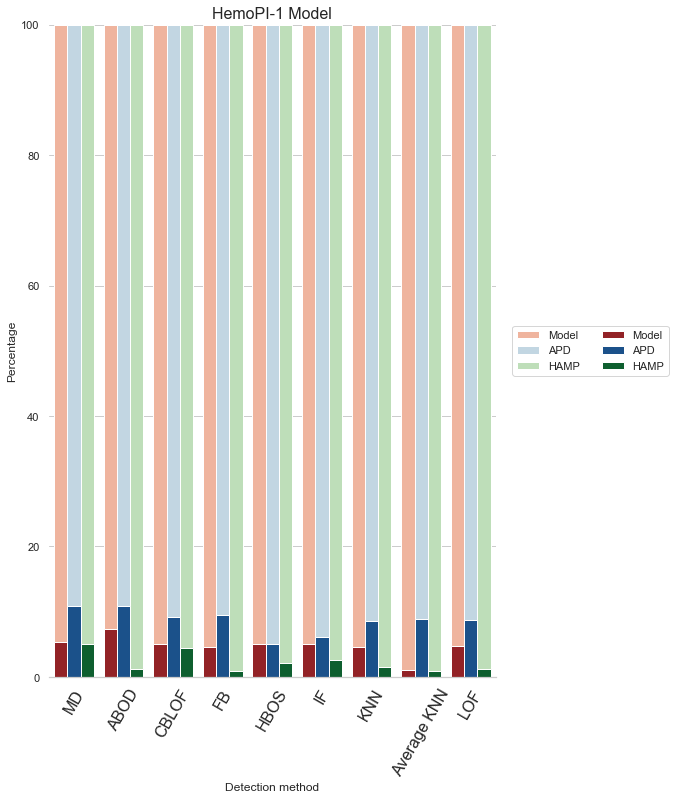

In [184]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 12))

# Plot the inliers
sns.barplot(x="Detection method", y="Total", hue='Group A', palette=['#fcae91', '#bdd7e7', '#bae4b3'], data=outlier_fractions[outlier_fractions['Group B'].str.contains('Model 1')])

# Plot the outliers
sns.barplot(x="Detection method", y="Outlier", hue='Group A', palette=['#a50f15', '#08519c', '#006d2c'], data=outlier_fractions[outlier_fractions['Group B'].str.contains('Model 1')])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="center right", frameon=True, bbox_to_anchor=(1.4, 0.5))
ax.set(ylim=(0, 100), ylabel="Percentage", xlabel="Detection method")
labels = ['MD', 'ABOD', 'CBLOF', 'FB', 'HBOS', 'IF', 'KNN', 'Average KNN', "LOF"] 
ax.set_xticklabels(labels, rotation=60, fontsize=16)
sns.despine(left=True)

plt.rcParams.update({'font.size': 16})
plt.title('HemoPI-1 Model', fontsize=16)
#plt.savefig(path.join(figpath, "Comparing Percentages of Inliers, Novelties and Outliers across all detection methods - HemoPI-1 model.pdf"))
#plt.close()
plt.show()

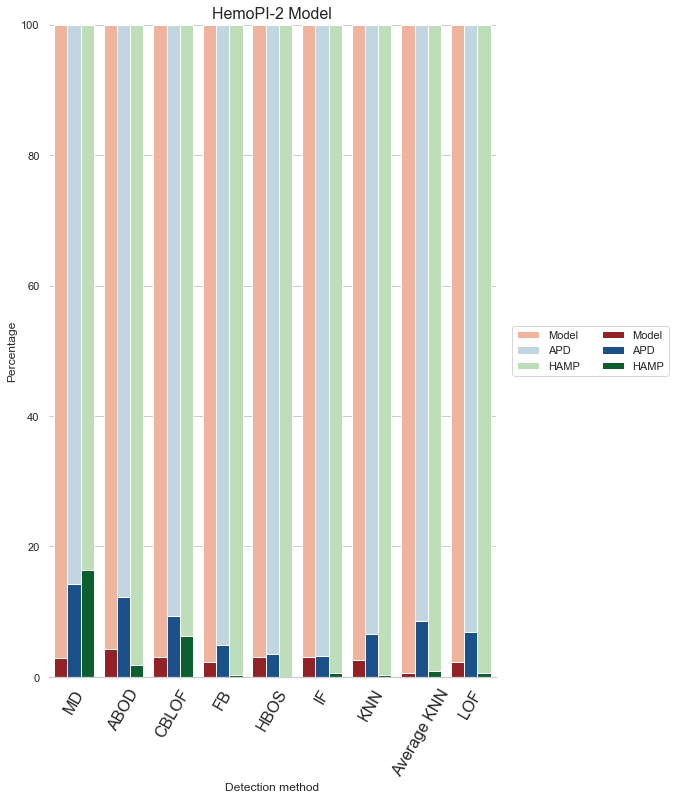

In [185]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 12))

# Plot the inliers
sns.barplot(x="Detection method", y="Total", hue='Group A', palette=['#fcae91', '#bdd7e7', '#bae4b3'], data=outlier_fractions[outlier_fractions['Group B'].str.contains('Model 2')])

# Plot the outliers
sns.barplot(x="Detection method", y="Outlier", hue='Group A', palette=['#a50f15', '#08519c', '#006d2c'], data=outlier_fractions[outlier_fractions['Group B'].str.contains('Model 2')])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="center right", frameon=True, bbox_to_anchor=(1.4, 0.5))
ax.set(ylim=(0, 100), ylabel="Percentage", xlabel="Detection method")
labels = ['MD', 'ABOD', 'CBLOF', 'FB', 'HBOS', 'IF', 'KNN', 'Average KNN', "LOF"] 
ax.set_xticklabels(labels, rotation=60, fontsize=16)
sns.despine(left=True)

plt.rcParams.update({'font.size': 16})
plt.title('HemoPI-2 Model', fontsize=16)
#plt.savefig(path.join(figpath, "Comparing Percentages of Inliers, Novelties and Outliers across all detection methods - HemoPI-2 model.pdf"))
#plt.close()
plt.show()

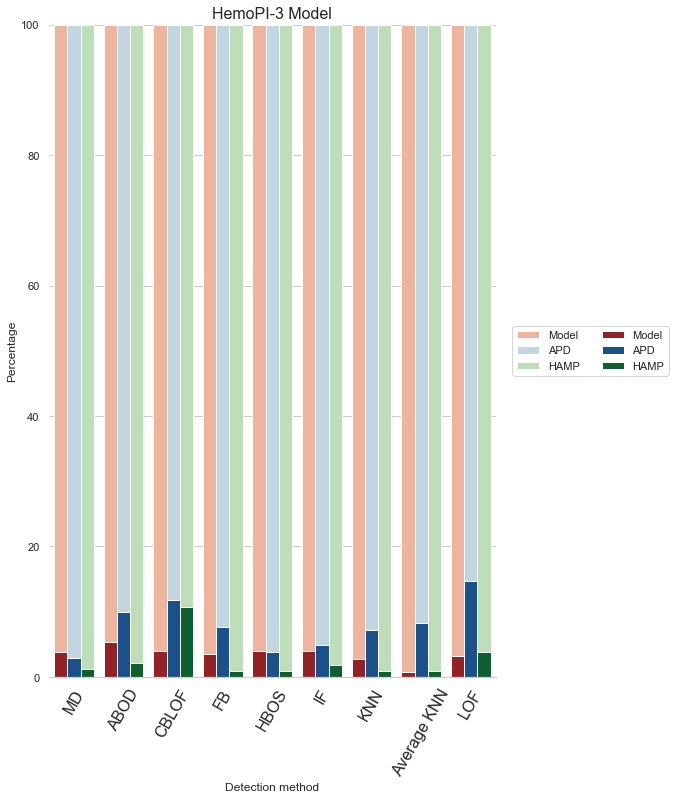

In [186]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 12))

# Plot the inliers
sns.barplot(x="Detection method", y="Total", hue='Group A', palette=['#fcae91', '#bdd7e7', '#bae4b3'], data=outlier_fractions[outlier_fractions['Group B'].str.contains('Model 3')])

# Plot the outliers
sns.barplot(x="Detection method", y="Outlier", hue='Group A', palette=['#a50f15', '#08519c', '#006d2c'], data=outlier_fractions[outlier_fractions['Group B'].str.contains('Model 3')])

# Add a legend and informative axis label
ax.legend(ncol=2, loc="center right", frameon=True, bbox_to_anchor=(1.4, 0.5))
ax.set(ylim=(0, 100), ylabel="Percentage", xlabel="Detection method")
labels = ['MD', 'ABOD', 'CBLOF', 'FB', 'HBOS', 'IF', 'KNN', 'Average KNN', "LOF"] 
ax.set_xticklabels(labels, rotation=60, fontsize=16)
sns.despine(left=True)

plt.rcParams.update({'font.size': 16})
plt.title('HemoPI-3 Model', fontsize=16)
#plt.savefig(path.join(figpath, "Comparing Percentages of Inliers, Novelties and Outliers across all detection methods - HemoPI-3 model.pdf"))
#plt.close()
plt.show()

#### Conclusions

We compared 8 multivariate outlier detection techniques (ABOD, CBLOF, FB, HBOS, IF , KNN, Average KNN, LOF) by either using the full 56-dimensional datasets (4 model sets, 2 test sets (total APD, True haemolytic peptides) or reducing each dataset to 2 dimensions with PCA, t-SNE and MDS.  For the HemoPI-1 model dataset and total APD dataset / HemoPI-1 model, we also compared the effect of outlier fractions using 3 different fractions of outliers (1, 5 and 10%).

- Comparing Outlier Detection Methods
Overall, Average KNN technique leads to the lowest number of novelties (training outliers) across all 4 model dataset while HBOD showed the lowest number of outliers using the total APD dataset for reduced datasets with MDS, t-SNE (2 dimensions) or full datasets (56 dimensions).

- Comparing multivariate matrices with MDS, PCA, t-SNE and 56D-matrix 
All outlier detection methods display results within the same ranges for all 4 model datasets for a given outlier fraction identifical to the univariate outlier analysis with Mahalanobis distance (e.g. HemoPI-1 model 0.05). The number of outliers differ drastically with the total APD dataset under the 4 models, independently of the multivariate datasets. For a given outlier fraction (e.g. HemoPI-1 model 0.05), PCA scored the lowest number of novelties with most Outlier Detection methods. Multidimensional Scaling of Mahalanobis distance (2D-MD) and t-SNE showed similar results and the highest number of novelties or outliers. On average, using the full extent of the datasets (56-dimensions) leads to a number of novelties or outliers comparable with our univariate analysis. When comparing scores between 56-dimensional matrices versus bidimensional t-SNE matrices, we observed that the number of outliers is usually higher with t-SNE (novelties levels remain similar). One can suggest that t-SNE dimensionality reduction technique result in the loss of information with the total APD dataset leading to a misclassification (outlier/inlier).

- Effect of the outlier fraction
For all datasets, the number of outliers or novelties increases with an increasing outlier fraction regardless the outlier detection technique used. 

- Picking the right OD technique = Average KNN versus Histogram-based Outlier Detection (HBOD) Techniques.

To understand which one of these techniques is closest to the 'truth', we consider the technique that scores the lowest number of novelties within the 4 model datasets. We also considered that peptides that were tested and validated experimentally should be part of predictive "space" from models - closest to the ground truth (our knowledge). We used an external validated dataset of 317 true haemolytic peptides from the total APD dataset and we evaluated the largest number of true haemolytic peptides identified as inliers (or lowest number of outliers) across all 4 models (for t-SNE matrices and 56-dimensional matrices). 

We observed that the "Average KNN" scores the lowest number of novelties across all 4 models with t-SNE-reduced datasets or 56-dimensional datasets. The differences appear in the test datasets, APD and HAMP, their number of outliers is higher when using t-SNE-reduced datasets. As we aim at choosing the method that both maximize the number of inliers among the 4 models and HAMP dataset, we consider that Average KNN using 56-dimensional datasets (and not reduced bidimensional datasets0 is the right technique. 

- Display inliers, novelties and outliers for each detection method onto scatterplots (probabilities versus distances).

Using Average KNN results, we report the inliers and outliers onto the projection (probabilities versus mahalanobis distance) and compared them to the univariate analysis with Mahalanobis distance.